<div style="text-align: center;">
<span style="color:#C1D3FE;font-size: 32px; font-weight: bold;">2a versão Notebook de Treinamento de Machine Learning: "Originadora e StartCard" de 05/08</span>
<br> <span style="color:#FFD1DC;"> Feito por Lucas Andrade entre 23 e 28 de Agosto de 2025 </span>
<br> <span style="color:#FFF5BA;"> a ser revisado por Felipe Bastos (Modificações)

<br>
<span style="color:#C1D3FE;">Lucas Rafael de Andrade Desenvolvimento de Software Ltda (59.088.726/0001-70)</span>

<span style="color:#C1D3FE;">Solicitado por Porto Real Asset</span>


Observação: esse notebook traz como features para o modelo as seguintes séries: 
Esfera do convênio,
Faixa população,
CAPAG,
Muitos contratos,
Tipo de produto,
Tipo de empregado,
Faixa de Idade,
Total de parcelas,
Valor da parcela, 
Populaçao no município, 
PIB Município

Falta: 
Revisar se os modelos estão consistentes e dar explicações sobre os resultados

### Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # sem usar
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.impute import SimpleImputer
import glob
import unicodedata
import re
import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import PartialDependenceDisplay
from lightgbm.callback import early_stopping as lgb_early_stopping
import shap
import optuna
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

c:\Users\Leo\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Função de Carregamento dos dados e preparação 
retorna um df com  as features, já

In [2]:
def carregar_e_preparar_dados(): # Renomeado para v3
    """
    Changelog: 
    1.  População e PIB são contínuas, mas separadas
        por esfera (municipal vs. estadual) para manter o contexto.
    1.  'CAPAG' transformada em uma feature numérica ordinal.
    1.  A idade do cliente ('_IdadeCliente') é mantida como contínua.
    1.  Adiciona o número da próxima parcela a vencer como feature.
    (mas eu não usei essa feat no modelo final, pq ela dá previsao quase perfeita)

    Retorna:
        pd.DataFrame: O dataframe final (df_ml), pronto para modelagem.
    """
    print("="*88)
    print("ETAPA 1: Carregando dados (VERSÃO PARA ML V3 - COM PRÓXIMA PARCELA)...")
    print("="*88)

    #! ##############################        PATHS         ##########################################
    path_starcard = r'C:\Users\Leo\Desktop\Porto_Real\portoauto\src\originadores\data\StarCard.xlsx'
    path_originadores = r'C:\Users\Leo\Desktop\Porto_Real\portoauto\src\originadores\data\Originadores.xlsx'
    path_relacoes = r'C:\Users\Leo\Desktop\Porto_Real\portoauto\src\fct_consig\relacoes.csv'
    path_contas_regionais_folder = r'C:\Users\Leo\Desktop\Porto_Real\portoauto\data_raw\dados_macro_adicionais\ibge\contas_regionais'
    #! ##############################################################################################
    #? Normaliza nome ############################################################################## 
    def normalizar_nome(texto):
        if not isinstance(texto, str): return ""
        texto = re.sub(r'^(PREF\.\s*|PRERF\.\s*|GOV\.\s*|AGN\s*-\s*)', '', texto, flags=re.IGNORECASE)
        texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
        texto = re.sub(r'[^A-Z0-9\s]', '', texto.upper())
        texto = re.sub(r'\s+', ' ', texto).strip()
        return texto
    #? ##############################################################################################
    df_starcard = pd.read_excel(path_starcard)
    cols_originadores = ['CCB', 'Data de Inclusão', 'Prazo', 'Valor Parcela', 'Produto', 'Convênio', 'CAPAG']
    try:
        df_originadores = pd.read_excel(path_originadores, usecols=cols_originadores)
    except ValueError:
        print("[ALERTA] Coluna 'CAPAG' não encontrada.")
        cols_originadores = [c for c in cols_originadores if c != 'CAPAG']
        df_originadores = pd.read_excel(path_originadores, usecols=cols_originadores)
    
    df_pib_ibge = pd.DataFrame()
    try:
        all_xlsx_files = glob.glob(os.path.join(path_contas_regionais_folder, '*.xlsx'))
        valid_files = [f for f in all_xlsx_files if not os.path.basename(f).startswith('~$')]
        if not valid_files: raise FileNotFoundError("Nenhum arquivo .xlsx válido foi encontrado.")
        latest_file = max(valid_files, key=os.path.getctime)
        print(f"[INFO] Lendo arquivo de Contas Regionais: {os.path.basename(latest_file)}")
        df_pib_ibge_full = pd.read_excel(latest_file, header=0)
        df_pib_ibge_full.columns = [str(col).replace('\n', ' ').strip() for col in df_pib_ibge_full.columns]
        ano_col_name = [col for col in df_pib_ibge_full.columns if "Ano" in col][0]
        pib_col_name = [col for col in df_pib_ibge_full.columns if "Produto Interno Bruto" in col][0]
        cod_uf_col_name = [col for col in df_pib_ibge_full.columns if "Unidade da Federação" in col][0]
        cod_mun_col_name = [col for col in df_pib_ibge_full.columns if "do Município" in col][0]
        cols_to_use = [ano_col_name, cod_uf_col_name, cod_mun_col_name, pib_col_name]
        df_pib_ibge_full = df_pib_ibge_full[cols_to_use]
        df_pib_ibge_full.columns = ['Ano', 'Codigo_UF', 'Codigo_Municipio', 'PIB']
        ano_recente = df_pib_ibge_full['Ano'].max()
        print(f"[INFO] Ano mais recente encontrado na base do IBGE: {ano_recente}. Filtrando dados...")
        df_pib_ibge = df_pib_ibge_full[df_pib_ibge_full['Ano'] == ano_recente].copy()
        for col in ['Codigo_UF', 'Codigo_Municipio']:
            df_pib_ibge[col] = pd.to_numeric(df_pib_ibge[col], errors='coerce')
        df_pib_ibge.dropna(subset=['Codigo_UF', 'Codigo_Municipio'], inplace=True)
        df_pib_ibge['Codigo_UF'] = df_pib_ibge['Codigo_UF'].astype(int)
        df_pib_ibge['Codigo_Municipio'] = df_pib_ibge['Codigo_Municipio'].astype(int)
        df_pib_estados = df_pib_ibge.groupby("Codigo_UF", as_index=False)['PIB'].sum().rename(columns={'PIB': 'PIB_Estadual'})
    except Exception as e:
        print(f"[ERRO] Falha ao carregar ou processar o arquivo de PIB: {e}.")

    df_relacoes = pd.DataFrame()
    try:
        cols_relacoes = ['Convênio', 'populacao', 'tipo', 'cod_uf', 'codigo', 'Nome']
        df_relacoes = pd.read_csv(path_relacoes, sep=';', usecols=cols_relacoes)
        df_relacoes['cod_uf'] = pd.to_numeric(df_relacoes['cod_uf'], errors='coerce').fillna(0).astype(int)
        df_relacoes['codigo'] = pd.to_numeric(df_relacoes['codigo'], errors='coerce').fillna(0).astype(int)
        mapa_uf = { 'ALAGOAS': 27, 'AMAZONAS': 13, 'ESPIRITO SANTO': 32, 'GOIAS': 52, 'MARANHAO': 21, 'PARAIBA': 25, 'PARANA': 41, 'PIAUI': 22, 'RIO DE JANEIRO': 33, 'RIO GRANDE DO NORTE': 24, 'SANTA CATARINA': 42, 'SAO PAULO': 35, 'TOCANTINS': 17, 'CEARA': 23, 'MATO GROSSO': 51 }
        print("[INFO] Corrigindo 'cod_uf' ausente para convênios de estado...")
        for nome_estado, codigo_uf in mapa_uf.items():
            mask = (df_relacoes['Convênio'].str.contains(nome_estado, case=False, na=False)) & (df_relacoes['tipo'] == 2)
            df_relacoes.loc[mask, 'cod_uf'] = codigo_uf
        if not df_pib_ibge.empty:
            df_relacoes = pd.merge(df_relacoes, df_pib_ibge[['Codigo_Municipio', 'PIB']], left_on='codigo', right_on='Codigo_Municipio', how='left')
            df_relacoes = pd.merge(df_relacoes, df_pib_estados, left_on='cod_uf', right_on='Codigo_UF', how='left')
            df_relacoes['PIB_Consolidado'] = np.where(df_relacoes['tipo'] == 1, df_relacoes['PIB'], df_relacoes['PIB_Estadual'])
        df_relacoes['Nome_Normalizado'] = df_relacoes['Nome'].apply(normalizar_nome)
    except FileNotFoundError:
        print(f"[ERRO] 'relacoes.csv' não encontrado.")

    if 'Data de Inclusão' in df_originadores.columns:
        df_originadores['Data de Inclusão'] = pd.to_datetime(df_originadores['Data de Inclusão'], errors='coerce')
        df_originadores = df_originadores.sort_values(['CCB', 'Data de Inclusão']).drop_duplicates(subset='CCB', keep='first')
    
    df_merged = pd.merge(df_starcard, df_originadores, on='CCB', how='left', suffixes=('', '_orig'))
    
    if 'Convênio' in df_merged.columns and not df_relacoes.empty:
        df_merged_original_convenio = df_merged['Convênio'].copy()
        df_merged['Convênio'] = df_merged['Convênio'].astype(str).str.upper().str.strip()
        df_relacoes_lookup = df_relacoes.drop_duplicates(subset='Convênio', keep='first').copy()
        df_relacoes_lookup['Convênio'] = df_relacoes_lookup['Convênio'].astype(str).str.upper().str.strip()
        features_externas = ['Convênio', 'populacao', 'PIB_Consolidado', 'tipo']
        features_existentes = [f for f in features_externas if f in df_relacoes_lookup.columns]
        df_merged = pd.merge(df_merged, df_relacoes_lookup[features_existentes], on='Convênio', how='left')
        df_merged['Convênio'] = df_merged_original_convenio

    if 'PIB_Consolidado' in df_merged.columns:
        nao_informados_mask = df_merged['PIB_Consolidado'].isnull()
        if nao_informados_mask.any():
            print(f"[INFO] {nao_informados_mask.sum()} registros não encontrados. Iniciando busca por fallback...")
            counts = df_relacoes['Nome_Normalizado'].value_counts()
            nomes_ambiguos = counts[counts > 1].index.tolist()
            if nomes_ambiguos:
                print(f"[ALERTA] Nomes de municípios ambíguos encontrados. Resolvendo pela maior população.")
            df_relacoes_sorted = df_relacoes.sort_values('populacao', ascending=False)
            df_relacoes_deduped = df_relacoes_sorted.drop_duplicates(subset='Nome_Normalizado', keep='first')
            mapa_fallback = df_relacoes_deduped.set_index('Nome_Normalizado')
            convenios_a_tratar = df_merged.loc[nao_informados_mask, 'Convênio'].unique()
            for conv in convenios_a_tratar:
                nome_normalizado = normalizar_nome(conv)
                if 'AGN - RIO GRANDE DO NORTE' in conv: nome_normalizado = 'RIO GRANDE DO NORTE'
                if nome_normalizado in mapa_fallback.index:
                    dados_encontrados = mapa_fallback.loc[nome_normalizado]
                    mask_update = df_merged['Convênio'] == conv
                    df_merged.loc[mask_update, 'populacao'] = dados_encontrados['populacao']
                    df_merged.loc[mask_update, 'PIB_Consolidado'] = dados_encontrados['PIB_Consolidado']
                    df_merged.loc[mask_update, 'tipo'] = dados_encontrados['tipo']
    
    #? lIMPEZA ##################################################################################
    df_base = df_merged.copy()
    del df_starcard, df_originadores, df_merged, df_relacoes, df_pib_ibge
    df_base = df_base.rename(columns={'Data Referencia': 'DataGeracao', 'Data Vencimento': 'DataVencimento', 'ID Cliente': 'SacadoID'})
    for col in ['DataGeracao', 'DataVencimento', 'Data de Nascimento']:
        if col in df_base.columns: df_base[col] = pd.to_datetime(df_base[col], errors='coerce')
    
    if 'Valor Parcela' in df_base.columns and df_base['Valor Parcela'].dtype == 'object':
        s = df_base['Valor Parcela'].astype(str).str.replace('R$', '', regex=False).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).str.strip()
        df_base['Valor Parcela'] = pd.to_numeric(s, errors='coerce')
        
    if 'Produto' in df_base.columns: df_base['Produto'] = df_base['Produto'].fillna('')
    if 'Convênio' in df_base.columns: df_base['Convênio'] = df_base['Convênio'].fillna('')
    
    if 'DataGeracao' in df_base.columns and 'DataVencimento' in df_base.columns:
        df_base['dias_de_atraso'] = (df_base['DataGeracao'] - df_base['DataVencimento']).dt.days
        
    condicoes_produto = [df_base['Produto'].str.contains('Empréstimo', case=False, na=False), df_base['Produto'].str.contains('Cartão RMC', case=False, na=False), df_base['Produto'].str.contains('Cartão Benefício', case=False, na=False)]
    opcoes_produto = ['Empréstimo', 'Cartão RMC', 'Cartão Benefício']
    df_base['_TipoProduto'] = np.select(condicoes_produto, opcoes_produto, default='Outros')
    
    condicoes_empregado = [df_base['Produto'].str.contains('Efetivo|Efetivio', case=False, na=False, regex=True), df_base['Produto'].str.contains('Temporário', case=False, na=False), df_base['Produto'].str.contains('CONTRATADO', case=False, na=False), df_base['Produto'].str.contains('Comissionado', case=False, na=False)]
    opcoes_empregado = ['Efetivo', 'Temporário', 'Contratado', 'Comissionado']
    df_base['_TipoEmpregado'] = np.select(condicoes_empregado, opcoes_empregado, default='Outros')
    
    condicoes_convenio = [df_base['Convênio'].str.contains(r'GOV\.|AGN -', case=False, na=False, regex=True), df_base['Convênio'].str.contains(r'PREF\.|PRERF', case=False, na=False, regex=True)]
    opcoes_convenio = ['Estadual', 'Municipal']
    df_base['_EsferaConvenio'] = np.select(condicoes_convenio, opcoes_convenio, default='Outros')
    
    if 'Data de Inclusão' not in df_base.columns: raise ValueError("Coluna 'Data de Inclusão' não encontrada.")
    df_base = df_base.sort_values(['SacadoID', 'Data de Inclusão', 'CCB'])
    df_base['_NumContratosAnteriores'] = df_base.groupby('SacadoID').cumcount()
    df_base['_MuitosContratos'] = (df_base['_NumContratosAnteriores'] >= 2).astype(int)
    
    if 'Data de Nascimento' in df_base.columns:
        base_idade = df_base['Data de Inclusão'].fillna(df_base.get('DataGeracao'))
        df_base['_IdadeCliente'] = (base_idade - df_base['Data de Nascimento']).dt.days / 365.25
        
    df_base['populacao_municipal'] = np.where(df_base['tipo'] == 1, df_base['populacao'].fillna(0), 0)
    df_base['PIB_municipal'] = np.where(df_base['tipo'] == 1, df_base['PIB_Consolidado'].fillna(0), 0)
    df_base['populacao_estadual'] = np.where(df_base['tipo'] == 2, df_base['populacao'].fillna(0), 0)
    df_base['PIB_estadual'] = np.where(df_base['tipo'] == 2, df_base['PIB_Consolidado'].fillna(0), 0)

    if 'CAPAG' in df_base.columns:
        print("[INFO] Mapeando CAPAG para variável numérica ordinal...")
        capag_mapa = {
            'A+': 6, 'A': 5, 'A-': 4,
            'B+': 3, 'B': 2, 'B-': 1,
            'C': 0, 'D': -1
        }
        df_base['CAPAG_Ordinal'] = df_base['CAPAG'].map(capag_mapa).fillna(-2)

    #? PARTE DA PRÓXIMA PARCELA #########################################################
    #?<AC> Note que essa feature pode introduzir um viés significativo,
    #?<AC>  pois contratos com parcelas futuras tendem a estar em melhor situação.
    # eu testei essa feat e realmente deu previsao perfeita, acabei não incluindo

    print("[INFO] Calculando o número da próxima parcela a vencer para cada contrato...")
    if 'DataGeracao' in df_base.columns and 'DataVencimento' in df_base.columns and 'PARCELA' in df_base.columns:
        
        df_futuras = df_base[df_base['DataVencimento'] >= df_base['DataGeracao']].copy()   #  filtra apns parcls com vencmn futro (ou no dia da gerco)
        df_futuras = df_futuras.sort_values('DataVencimento')  # ordna por data de vencmn para encntr a mais prxma
        df_proxima_parcela = df_futuras.drop_duplicates(subset='CCB', keep='first')  #  pega a primr ocorrn de cada ccb (que agra eh a prxma a vencr)
        df_proxima_parcela = df_proxima_parcela[['CCB', 'PARCELA']].rename(columns={'PARCELA': 'Proxima_Parcela_Num'}) # selcn as colns de intrss e renm
        df_base = pd.merge(df_base, df_proxima_parcela, on='CCB', how='left')  # junta essa infrmc de volta no datfrm princp
        df_base['Proxima_Parcela_Num'] = df_base['Proxima_Parcela_Num'].fillna(0).astype(int)  # prench com 0 os contrt que nao tem parcls futrs
    else:
        print("[ALERTA] Colunas necessárias para calcular a próxima parcela não encontradas. Feature não criada.")


    #? Preparacao final ############################################################################
    atraso_por_ccb = df_base.groupby('CCB', as_index=False)['dias_de_atraso'].max().rename(columns={'dias_de_atraso': 'max_dias_atraso'})
    for k in [1, 30, 60, 90]: atraso_por_ccb[f'Vencido_{k}d_Flag'] = (atraso_por_ccb['max_dias_atraso'] >= k).astype(int)
    
    df_base['DataInclRef'] = df_base['Data de Inclusão'].fillna(df_base.get('DataGeracao'))
    snapshots = df_base.sort_values(['CCB', 'DataInclRef', 'DataVencimento'])
    primeiro_snap = snapshots.groupby('CCB', as_index=False).first()
    
    #! LISTA DE FEATURES do modelo #################################################################
    features_para_modelo = [
        'CCB', 'Prazo', 'Valor Parcela', 
        '_TipoProduto', '_TipoEmpregado', '_EsferaConvenio', 
        '_MuitosContratos', 
        '_IdadeCliente',
        'populacao_municipal', 'PIB_municipal',
        'populacao_estadual', 'PIB_estadual',
        'CAPAG_Ordinal' #,    'Proxima_Parcela_Num' #! <-- RUIM!! ele dá previsao quase perfeita
    ]
    #! #############################################################################################
    ausentes = sorted(list(set(features_para_modelo) - set(primeiro_snap.columns)))
    if ausentes: print(f"[AVISO] Features ausentes e removidas: {ausentes}")
    
    features_existentes = [f for f in features_para_modelo if f in primeiro_snap.columns]
    df_features = primeiro_snap[features_existentes]
    
    df_ml = pd.merge(df_features, atraso_por_ccb, on='CCB', how='inner').rename(columns={
        'Prazo': 'Total_Parcelas', 'Valor Parcela': 'Valor_Parcela', 
        '_EsferaConvenio': 'Esfera_convenio', '_MuitosContratos': 'Muitos_Contratos',
        '_TipoProduto': 'Tipo_Produto', '_TipoEmpregado': 'Tipo_Empregado',
        '_IdadeCliente': 'Idade_Cliente',
        'Proxima_Parcela_Num': 'Proxima_Parcela_Num'
    })
    
    print(f"\n<INFO> Dataset para ML criado com {df_ml.shape[0]} linhas e {df_ml.shape[1]} colunas.")
    print("\n<INFO> Verificando as primeiras linhas e os tipos de dados do dataframe final:")
    print(df_ml.head())
    print("\n")
    df_ml.info()
        
    return df_ml

### Funções De Treino e Avaliação

#### Auxiliares

In [ ]:
# (Função Auxiliar)
#! iNSTALE as Bibiotecas: 
#! ======================
# %pip install optuna
# %pip install shap
#! ======================
def _mostrar_feature_importance(pipeline, X_train_cols):
    """

    """
    try:
        classifier = pipeline.named_steps['classifier']
        preprocessor = pipeline.named_steps['preprocessor']
        
        cat_features = preprocessor.transformers_[1][2]
        num_features = preprocessor.transformers_[0][2]
        cat_features_out = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
        feature_names = num_features + list(cat_features_out)

        # Print das importâncias
        if hasattr(classifier, 'feature_importances_'):
            importances = pd.Series(classifier.feature_importances_, index=feature_names)
            print("Top 15 importâncias:")
            print(importances.abs().sort_values(ascending=False).head(15))
            
        elif hasattr(classifier, 'coef_'):
            importances = pd.Series(classifier.coef_[0], index=feature_names)
            print("Top 15 importâncias (valor absoluto):")
            print(importances.abs().sort_values(ascending=False).head(15))
            
            #* específico da regressão logística
            if isinstance(classifier, LogisticRegression):
                print("\n   --- Coeficientes da Regressão Logística ---")
                print("   Maiores Coeficientes Positivos (aumentam o risco):")
                print(importances.sort_values(ascending=False).head(5))
                print("\n   Maiores Coeficientes Negativos (diminuem o risco):")
                print(importances.sort_values(ascending=True).head(5))
        else:
            print("[INFO] Modelo não possui um atributo de importância de features padrão.")

    except Exception as e:
        print(f"[AVISO] Não foi possível extrair feature importance: {e}")



In [ ]:
# (funcao auxiliar)
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

def _report_overfit(pipeline, name, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Calcula e imprime métricas para os conjuntos de treino, validação e teste,
    alertando sobre possível overfitting.
    """
    def _met(Xs, ys):
        # Gera predições de probabilidade para a classe positiva
        p = pipeline.predict_proba(Xs)[:, 1]
        
        # Calcula as métricas
        auc = roc_auc_score(ys, p)
        auprc = average_precision_score(ys, p)
        # Garante que p não seja exatamente 0 ou 1 para evitar problemas com log_loss
        p_clipped = np.clip(p, 1e-15, 1 - 1e-15)
        ll = log_loss(ys, p_clipped)
        
        return (auc, auprc, ll)

    # Calcula as métricas para cada conjunto de dados
    auc_tr, auprc_tr, ll_tr = _met(X_train, y_train)
    auc_va, auprc_va, ll_va = _met(X_val, y_val)
    auc_te, auprc_te, ll_te = _met(X_test, y_test)
    
    # Imprime o relatório
    print("\n--- Relatório de Performance e Overfitting ---")
    print(f"[{name}] Treino   : AUC={auc_tr:.4f} | AUPRC={auprc_tr:.4f} | LogLoss={ll_tr:.4f}")
    print(f"[{name}] Validação: AUC={auc_va:.4f} | AUPRC={auprc_va:.4f} | LogLoss={ll_va:.4f}")
    print(f"[{name}] Teste    : AUC={auc_te:.4f} | AUPRC={auprc_te:.4f} | LogLoss={ll_te:.4f}")
    
    # Calcula a diferença (gap) entre treino e validação
    gap = auc_tr - auc_va
    if gap > 0.05: # Um threshold comum é 5%, mas pode ser ajustado
        print(f"🚨 [ALERTA] Possível overfitting em '{name}': Gap AUC Treino-Validação = {gap:.4f}")
    else:
        print(f"✅ [INFO] Gap Treino-Validação saudável para '{name}': {gap:.4f}")
    print("-" * 44)

#### Principal: treinamento da função 

In [16]:
def treinar_e_avaliar(df_ml, target):
    """

    """
    #- mostra os coefcn postvs e negtvs da regrss logstc.
    #- manthm as funcnl da v6.
    print("\n" + "="*88)
    print(f"   ETAPA 1: TREINANDO MODELOS BASE PARA O ALVO: {target}")
    print("="*88)

    #! Objetivos de previsão ####################################################################
    targets_all = ['Vencido_1d_Flag', 'Vencido_30d_Flag', 'Vencido_60d_Flag', 'Vencido_90d_Flag']
    #! ##########################################################################################
    X = df_ml.drop(columns=targets_all + ['CCB', 'max_dias_atraso'])
    y = df_ml[target]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    #? Pré-processamento ##########################################################################
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('power_transform', PowerTransformer()), ('scaler', RobustScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)], remainder='passthrough')
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    scale_pos_weight = neg / pos if pos > 0 else 1.0
    #? ############################################################################################
    #! ESCOLHER MODELOS      #########################################
    models = {
        "Regressão Logística": LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000, n_jobs=-1),
        "Random Forest":       RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        "XGBoost":             xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight, n_jobs=-1, early_stopping_rounds=20),
        "LightGBM":            lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight, n_jobs=-1, verbosity=-1),
        "Rede Neural (MLP)":   MLPClassifier(random_state=42, max_iter=500, early_stopping=True, hidden_layer_sizes=(100, 50))
    }
    #! ###############################################################
    modelos_para_otimizar = {}
    preprocessor.fit(X_train)

    for name, model in models.items():
        print(f"\n--- Treinando {name} ---")
        full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        fit_params = {}
        if name in ["XGBoost", "LightGBM", "Rede Neural (MLP)"]:
            X_val_transformed = preprocessor.transform(X_val)
            if name == "XGBoost":
                fit_params = {'classifier__eval_set': [(X_val_transformed, y_val)]}
            elif name == "LightGBM":
                fit_params = {
                    'classifier__eval_set': [(X_val_transformed, y_val)],
                    'classifier__callbacks': [lgb_early_stopping(20, verbose=False)]
                }
        
        full_pipeline.fit(X_train, y_train, **fit_params)
        y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        # Gera o relatório completo de overfitting
        _report_overfit(full_pipeline, name, X_train, y_train, X_val, y_val, X_test, y_test)

        
        print(f"Performance no CONJUNTO DE TESTE -> ROC-AUC: {auc:.4f}")

        _mostrar_feature_importance(full_pipeline, X.columns)
        
        if name in ["Random Forest", "XGBoost", "LightGBM"]:
            modelos_para_otimizar[name] = {'pipeline': full_pipeline, 'score_base': auc}
            
    return modelos_para_otimizar, preprocessor, X_train, y_train, X_val, y_val, X_test, y_test

#### otimizar modelos

In [ ]:
# nessa versão, to usando penalização para proteger do overfit, buscando hiperparms
def otimizar_modelos_selecionados(modelos_para_otimizar, preprocessor, 
                                  X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n" + "="*88)
    print("   ETAPA 2: OTIMIZANDO HIPERPARÂMETROS (COM FOCO EM REGULARIZAÇÃO)")
    print("="*88)

    todos_params_otimizados = {}
    
    for nome_modelo, info in modelos_para_otimizar.items():
        pipeline_base = info['pipeline']
        print(f"\n--- Otimizando {nome_modelo} ---")
        
        X_train_transformed = preprocessor.transform(X_train)
        X_val_transformed = preprocessor.transform(X_val)

        def objective(trial):
            modelo_classe = pipeline_base.named_steps['classifier'].__class__.__name__
            
            if "LGBM" in modelo_classe:
                print("[Optuna] Buscando parâmetros para LightGBM...")
                param = {
                    'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 50),
                    'max_depth': trial.suggest_int('max_depth', 4, 8),
                    # --- Parâmetros de Regularização Adicionados ---
                    'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0, log=True),
                    'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0, log=True),
                    'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
                }
                model = lgb.LGBMClassifier(**param, random_state=42, verbosity=-1)

            elif "XGB" in modelo_classe:
                print("[Optuna] Buscando parâmetros para XGBoost...")
                param = {
                    'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                    'max_depth': trial.suggest_int('max_depth', 3, 7),
                    #  Parâmetros de Regularização
                    'alpha': trial.suggest_float('alpha', 0.01, 1.0, log=True),      # L1- laso
                    'lambda': trial.suggest_float('lambda', 0.01, 1.0, log=True),     # L2 - ridge
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
                }
                model = xgb.XGBClassifier(**param, random_state=42, eval_metric='logloss')

            elif "Forest" in modelo_classe:
                print("[Optuna] Buscando parâmetros para Random Forest...")
                param = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 700),
                    # Parms Regularizacao
                    'max_depth': trial.suggest_int('max_depth', 8, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 5, 50),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
                    'max_features': trial.suggest_float('max_features', 0.3, 0.7) 
                }
                model = RandomForestClassifier(**param, random_state=42, n_jobs=-1)
            
            model.fit(X_train_transformed, y_train)
            preds = model.predict_proba(X_val_transformed)[:, 1]
            return roc_auc_score(y_val, preds)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50, show_progress_bar=True) # Aumentei um pouco o n_trials para explorar o novo espaço de busca

        print(f"Melhor ROC-AUC na validação para {nome_modelo}: {study.best_value:.4f}")
        todos_params_otimizados[nome_modelo] = study.best_params

        # verificação pos-opt- quero ver se tem overfit
        print(f"\n[INFO] Verificando overfitting do modelo '{nome_modelo}' com os melhores parâmetros...")
        
        melhores_params = study.best_params
        modelo_classe = pipeline_base.named_steps['classifier'].__class__
        
        # Add parâmetros fixos que não estão na busca do optuna
        fixed_params = {'random_state': 42, 'n_jobs': -1}
        if "XGB" in modelo_classe.__name__:
            fixed_params['eval_metric'] = 'logloss'
        elif "LGBM" in modelo_classe.__name__:
            fixed_params['verbosity'] = -1
            
        modelo_otimizado = modelo_classe(**melhores_params, **fixed_params)
        
        pipeline_otimizado = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', modelo_otimizado)
        ])
        
        pipeline_otimizado.fit(X_train, y_train)
        
        _report_overfit(pipeline_otimizado, f"{nome_modelo} (Otimizado e Regularizado)", 
                        X_train, y_train, X_val, y_val, X_test, y_test)
        
    return todos_params_otimizados

#### Funcao de Gráficos de Shap

In [ ]:

#?#################################################################
#? Referências :
#? https://medium.com/data-science/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
#?#################################################################
def explicar_e_diagnosticar_modelo(pipeline_final, X_train, X_test):
    """
    Gera o gráfico SHAP e realiza um diagnóstico do modelo...
    """
    print("\n" + "="*88)
    print("   ETAPA 3: GERANDO EXPLICAÇÕES E DIAGNÓSTICO COM SHAP (VERSÃO ROBUSTA)")
    print("="*88)
    
    # calculo dos shap com o pipe
    preprocessor = pipeline_final.named_steps['preprocessor']
    classifier = pipeline_final.named_steps['classifier']
    modelo_classe = classifier.__class__.__name__

    X_test_transformed = preprocessor.transform(X_test)
    
    print("Usando TreeExplainer para modelo baseado em árvore...")
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_test_transformed)

    
    try: # nomes das feats
        cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(preprocessor.transformers_[1][2])
        num_features = preprocessor.transformers_[0][2]
        feature_names = num_features + list(cat_features)
        X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
    except Exception as e:
        print(f"Aviso ao obter nomes de features: {e}")
        X_test_transformed_df = pd.DataFrame(X_test_transformed)
        feature_names = X_test_transformed_df.columns.tolist()

    

    if isinstance(shap_values, list):
    # id o formato da saída do SHAP e extrai os
    # valores para a classe positiva classe 1
    # faco isso por causa das diferencas nas bibliotecas
        print("[INFO] Formato de saída SHAP: Lista (típico de XGBoost/LGBM). Selecionando índice 1.")
        plot_values = shap_values[1]
    elif shap_values.ndim == 3:
        print("[INFO] Formato de saída SHAP: Array 3D (típico de RandomForest). Selecionando slice [:, :, 1].")
        plot_values = shap_values[:, :, 1]
    else:
        print("[INFO] Formato de saída SHAP: Array 2D (típico de regressão).")
        plot_values = shap_values

    # GRÁFICO ------------------------------------>
    print("\nGerando gráfico SHAP Summary Plot...")
    shap.summary_plot(plot_values, X_test_transformed_df, show=True, max_display=15)

    # DIAGNÓSTICO -------------------------------->
    print("\n" + "-"*40)
    print("   DIAGNÓSTICO DE IMPORTÂNCIA DE FEATURES")
    print("-"*40)

    if hasattr(classifier, 'feature_importances_'):
        importancias_modelo = pd.DataFrame({
            'Feature': feature_names,
            'Importance': classifier.feature_importances_
        }).sort_values('Importance', ascending=False)
        print("\n--- Top 10 Features (Importância interna do modelo) ---\n")
        print(importancias_modelo.head(10))
    else:
        print("\n[INFO] O modelo não possui o atributo 'feature_importances_'.")

    mean_abs_shap = np.abs(plot_values).mean(axis=0)
    shap_summary = pd.DataFrame({
        'Feature': feature_names,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values('MeanAbsSHAP', ascending=False)
    print("\n\n--- Top 10 Features (Média do valor absoluto SHAP) ---\n")
    print(shap_summary.head(10))
    print("\n" + "="*88)

### Execução

#### Ler dados (3 a 5 min)

In [7]:
#! demorado (até 4m30s)
df_ml = carregar_e_preparar_dados()

#print("\nBase rates dos alvos (df_ml):") # ( relatório rápido de base rates por label)
#print(df_ml[['Vencido_1d_Flag','Vencido_30d_Flag','Vencido_60d_Flag','Vencido_90d_Flag']].mean().round(4))


ETAPA 1: Carregando dados (VERSÃO PARA ML V3 - COM PRÓXIMA PARCELA)...
[INFO] Lendo arquivo de Contas Regionais: PIB dos Municípios - base de dados 2010-2021.xlsx
[INFO] Ano mais recente encontrado na base do IBGE: 2021. Filtrando dados...
[INFO] Corrigindo 'cod_uf' ausente para convênios de estado...
[INFO] 36940 registros não encontrados. Iniciando busca por fallback...
[ALERTA] Nomes de municípios ambíguos encontrados. Resolvendo pela maior população.
[INFO] Mapeando CAPAG para variável numérica ordinal...
[INFO] Calculando o número da próxima parcela a vencer para cada contrato...

<INFO> Dataset para ML criado com 6838 linhas e 18 colunas.

<INFO> Verificando as primeiras linhas e os tipos de dados do dataframe final:
        CCB  Total_Parcelas  Valor_Parcela      Tipo_Produto Tipo_Empregado  \
0  41137443              48          43.92        Cartão RMC        Efetivo   
1  41144516              48         170.00        Cartão RMC        Efetivo   
2  41144710              36   

#### Treinar Modelos e Avaliar (4 a 5 min)

<span style="color:#FFD1DC;"> Markdowns Removidos </span>

##### TREINAMENTO DOS MODELOS BASE
<span style="color:#FFEEBC;"> Treina todos os modelos e seleciona os 3 melhores para otimizar

In [17]:
alvo_principal = 'Vencido_60d_Flag'


(modelos_para_otimizar, preprocessor, 
    X_train, y_train, X_val, y_val, X_test, y_test) = treinar_e_avaliar(df_ml, target=alvo_principal)



   ETAPA 1: TREINANDO MODELOS BASE PARA O ALVO: Vencido_60d_Flag

--- Treinando Regressão Logística ---

--- Relatório de Performance e Overfitting ---
[Regressão Logística] Treino   : AUC=0.8268 | AUPRC=0.8201 | LogLoss=0.4842
[Regressão Logística] Validação: AUC=0.8413 | AUPRC=0.8439 | LogLoss=0.4663
[Regressão Logística] Teste    : AUC=0.8312 | AUPRC=0.8158 | LogLoss=0.4759
✅ [INFO] Gap Treino-Validação saudável para 'Regressão Logística': -0.0145
--------------------------------------------
Performance no CONJUNTO DE TESTE -> ROC-AUC: 0.8312
Top 15 importâncias (valor absoluto):
Tipo_Empregado_Efetivo       4.643489
Tipo_Empregado_Temporário    3.789727
Tipo_Empregado_Outros        3.027727
Tipo_Empregado_Contratado    2.129667
populacao_municipal          1.928197
PIB_municipal                1.430390
Tipo_Produto_Empréstimo      1.208116
PIB_estadual                 0.786895
populacao_estadual           0.678025
Valor_Parcela                0.357971
Tipo_Produto_Cartão RMC      

##### OTIMIZAÇÃO DOS HIPERPARÂMETROS
<span style="color:#FFEEBC;"> Otimizo os 3 melhores e retorna os melhores parâmetros para cada um

In [21]:
params_otimizados_dict = otimizar_modelos_selecionados(
    modelos_para_otimizar, preprocessor, 
    X_train, y_train, X_val, y_val, X_test, y_test 
)
X_train_val = pd.concat([X_train, X_val])  # Junta os dados de treino e validação para o treinamento final
y_train_val = pd.concat([y_train, y_val])


[I 2025-08-28 15:21:59,658] A new study created in memory with name: no-name-77671135-7cdd-49ff-b357-e4d46f5f09cb



   ETAPA 2: OTIMIZANDO HIPERPARÂMETROS (COM FOCO EM REGULARIZAÇÃO)

--- Otimizando Random Forest ---


  0%|          | 0/50 [00:00<?, ?it/s]

[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:   2%|▏         | 1/50 [00:01<00:52,  1.07s/it]

[I 2025-08-28 15:22:00,753] Trial 0 finished with value: 0.8958083113139563 and parameters: {'n_estimators': 108, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 16, 'max_features': 0.8958424561539178}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:   4%|▍         | 2/50 [00:06<02:52,  3.59s/it]

[I 2025-08-28 15:22:06,108] Trial 1 finished with value: 0.88883681925809 and parameters: {'n_estimators': 584, 'max_depth': 15, 'min_samples_split': 44, 'min_samples_leaf': 32, 'max_features': 0.9433789501178211}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:   6%|▌         | 3/50 [00:09<02:42,  3.45s/it]

[I 2025-08-28 15:22:09,374] Trial 2 finished with value: 0.8863532051062075 and parameters: {'n_estimators': 449, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 49, 'max_features': 0.8503008756230326}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:   8%|▊         | 4/50 [00:11<02:15,  2.94s/it]

[I 2025-08-28 15:22:11,548] Trial 3 finished with value: 0.8891177807899524 and parameters: {'n_estimators': 253, 'max_depth': 18, 'min_samples_split': 25, 'min_samples_leaf': 46, 'max_features': 0.6601626934564301}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:  10%|█         | 5/50 [00:16<02:38,  3.52s/it]

[I 2025-08-28 15:22:16,071] Trial 4 finished with value: 0.8931842163961429 and parameters: {'n_estimators': 665, 'max_depth': 11, 'min_samples_split': 25, 'min_samples_leaf': 27, 'max_features': 0.6780881676479052}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:  12%|█▏        | 6/50 [00:17<02:03,  2.80s/it]

[I 2025-08-28 15:22:17,493] Trial 5 finished with value: 0.8928646494629559 and parameters: {'n_estimators': 187, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 27, 'max_features': 0.7923400325640214}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:  14%|█▍        | 7/50 [00:19<01:39,  2.32s/it]

[I 2025-08-28 15:22:18,825] Trial 6 finished with value: 0.8877751707216636 and parameters: {'n_estimators': 141, 'max_depth': 20, 'min_samples_split': 27, 'min_samples_leaf': 49, 'max_features': 0.6048665649127012}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:  16%|█▌        | 8/50 [00:23<02:10,  3.11s/it]

[I 2025-08-28 15:22:23,624] Trial 7 finished with value: 0.8955134089427268 and parameters: {'n_estimators': 545, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 19, 'max_features': 0.9345366148298755}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 0. Best value: 0.895808:  18%|█▊        | 9/50 [00:27<02:10,  3.18s/it]

[I 2025-08-28 15:22:26,952] Trial 8 finished with value: 0.8877655193713325 and parameters: {'n_estimators': 528, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 48, 'max_features': 0.6520639911242812}. Best is trial 0 with value: 0.8958083113139563.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 9. Best value: 0.900802:  20%|██        | 10/50 [00:29<02:00,  3.02s/it]

[I 2025-08-28 15:22:29,640] Trial 9 finished with value: 0.9008023489241962 and parameters: {'n_estimators': 285, 'max_depth': 14, 'min_samples_split': 46, 'min_samples_leaf': 7, 'max_features': 0.8501707760814416}. Best is trial 9 with value: 0.9008023489241962.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 9. Best value: 0.900802:  22%|██▏       | 11/50 [00:32<01:50,  2.83s/it]

[I 2025-08-28 15:22:32,014] Trial 10 finished with value: 0.8987594797707698 and parameters: {'n_estimators': 349, 'max_depth': 12, 'min_samples_split': 50, 'min_samples_leaf': 7, 'max_features': 0.5378659771647807}. Best is trial 9 with value: 0.9008023489241962.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 9. Best value: 0.900802:  24%|██▍       | 12/50 [00:34<01:43,  2.73s/it]

[I 2025-08-28 15:22:34,521] Trial 11 finished with value: 0.9004259462612814 and parameters: {'n_estimators': 320, 'max_depth': 13, 'min_samples_split': 48, 'min_samples_leaf': 5, 'max_features': 0.5000506959403797}. Best is trial 9 with value: 0.9008023489241962.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  26%|██▌       | 13/50 [00:37<01:39,  2.68s/it]

[I 2025-08-28 15:22:37,088] Trial 12 finished with value: 0.9010951065509077 and parameters: {'n_estimators': 317, 'max_depth': 13, 'min_samples_split': 39, 'min_samples_leaf': 5, 'max_features': 0.7698659280664479}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  28%|██▊       | 14/50 [00:39<01:33,  2.58s/it]

[I 2025-08-28 15:22:39,447] Trial 13 finished with value: 0.8991197968497994 and parameters: {'n_estimators': 258, 'max_depth': 16, 'min_samples_split': 38, 'min_samples_leaf': 13, 'max_features': 0.764028282243376}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  30%|███       | 15/50 [00:42<01:35,  2.72s/it]

[I 2025-08-28 15:22:42,501] Trial 14 finished with value: 0.8991433890394976 and parameters: {'n_estimators': 403, 'max_depth': 11, 'min_samples_split': 36, 'min_samples_leaf': 10, 'max_features': 0.8004840204722947}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  32%|███▏      | 16/50 [00:45<01:28,  2.62s/it]

[I 2025-08-28 15:22:44,874] Trial 15 finished with value: 0.8952871383960741 and parameters: {'n_estimators': 261, 'max_depth': 17, 'min_samples_split': 36, 'min_samples_leaf': 20, 'max_features': 0.8576218293482594}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  34%|███▍      | 17/50 [00:49<01:40,  3.04s/it]

[I 2025-08-28 15:22:48,889] Trial 16 finished with value: 0.8998297072852682 and parameters: {'n_estimators': 443, 'max_depth': 14, 'min_samples_split': 41, 'min_samples_leaf': 5, 'max_features': 0.9988536066728708}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  36%|███▌      | 18/50 [00:51<01:33,  2.93s/it]

[I 2025-08-28 15:22:51,558] Trial 17 finished with value: 0.8907917538862771 and parameters: {'n_estimators': 325, 'max_depth': 13, 'min_samples_split': 32, 'min_samples_leaf': 35, 'max_features': 0.7326987691911393}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  38%|███▊      | 19/50 [00:53<01:16,  2.48s/it]

[I 2025-08-28 15:22:52,994] Trial 18 finished with value: 0.8963359184653923 and parameters: {'n_estimators': 179, 'max_depth': 10, 'min_samples_split': 45, 'min_samples_leaf': 12, 'max_features': 0.7122289274497885}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  40%|████      | 20/50 [00:56<01:20,  2.69s/it]

[I 2025-08-28 15:22:56,191] Trial 19 finished with value: 0.8943809838372054 and parameters: {'n_estimators': 371, 'max_depth': 18, 'min_samples_split': 30, 'min_samples_leaf': 23, 'max_features': 0.8512746022416129}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  42%|████▏     | 21/50 [00:58<01:09,  2.41s/it]

[I 2025-08-28 15:22:57,940] Trial 20 finished with value: 0.8993878899145534 and parameters: {'n_estimators': 207, 'max_depth': 13, 'min_samples_split': 42, 'min_samples_leaf': 10, 'max_features': 0.8086469195320524}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  44%|████▍     | 22/50 [01:00<01:07,  2.42s/it]

[I 2025-08-28 15:23:00,390] Trial 21 finished with value: 0.8994168439655469 and parameters: {'n_estimators': 307, 'max_depth': 13, 'min_samples_split': 49, 'min_samples_leaf': 7, 'max_features': 0.5044710327672439}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  46%|████▌     | 23/50 [01:03<01:05,  2.44s/it]

[I 2025-08-28 15:23:02,857] Trial 22 finished with value: 0.9010414879379569 and parameters: {'n_estimators': 299, 'max_depth': 14, 'min_samples_split': 46, 'min_samples_leaf': 5, 'max_features': 0.574833472443087}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  48%|████▊     | 24/50 [01:06<01:09,  2.67s/it]

[I 2025-08-28 15:23:06,053] Trial 23 finished with value: 0.898645808311314 and parameters: {'n_estimators': 428, 'max_depth': 15, 'min_samples_split': 40, 'min_samples_leaf': 15, 'max_features': 0.5899521430822278}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  50%|█████     | 25/50 [01:08<01:03,  2.52s/it]

[I 2025-08-28 15:23:08,250] Trial 24 finished with value: 0.8992002247692256 and parameters: {'n_estimators': 277, 'max_depth': 14, 'min_samples_split': 46, 'min_samples_leaf': 9, 'max_features': 0.7681277903121565}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  52%|█████▏    | 26/50 [01:10<00:56,  2.37s/it]

[I 2025-08-28 15:23:10,246] Trial 25 finished with value: 0.8974822844102811 and parameters: {'n_estimators': 218, 'max_depth': 12, 'min_samples_split': 33, 'min_samples_leaf': 16, 'max_features': 0.7092005206666226}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  54%|█████▍    | 27/50 [01:13<01:01,  2.66s/it]

[I 2025-08-28 15:23:13,596] Trial 26 finished with value: 0.9000902937442092 and parameters: {'n_estimators': 385, 'max_depth': 16, 'min_samples_split': 44, 'min_samples_leaf': 5, 'max_features': 0.8918897008301196}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  56%|█████▌    | 28/50 [01:16<00:55,  2.54s/it]

[I 2025-08-28 15:23:15,855] Trial 27 finished with value: 0.889352630314677 and parameters: {'n_estimators': 303, 'max_depth': 12, 'min_samples_split': 21, 'min_samples_leaf': 42, 'max_features': 0.6077659874854519}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  58%|█████▊    | 29/50 [01:18<00:55,  2.62s/it]

[I 2025-08-28 15:23:18,679] Trial 28 finished with value: 0.8957589821900415 and parameters: {'n_estimators': 353, 'max_depth': 16, 'min_samples_split': 38, 'min_samples_leaf': 20, 'max_features': 0.8270539532688904}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  60%|██████    | 30/50 [01:19<00:42,  2.13s/it]

[I 2025-08-28 15:23:19,650] Trial 29 finished with value: 0.8962994578085859 and parameters: {'n_estimators': 104, 'max_depth': 14, 'min_samples_split': 47, 'min_samples_leaf': 16, 'max_features': 0.8830983143130209}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  62%|██████▏   | 31/50 [01:23<00:49,  2.62s/it]

[I 2025-08-28 15:23:23,411] Trial 30 finished with value: 0.8981482275831304 and parameters: {'n_estimators': 509, 'max_depth': 11, 'min_samples_split': 42, 'min_samples_leaf': 12, 'max_features': 0.566628714487629}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  64%|██████▍   | 32/50 [01:26<00:45,  2.52s/it]

[I 2025-08-28 15:23:25,702] Trial 31 finished with value: 0.9004731306406781 and parameters: {'n_estimators': 316, 'max_depth': 13, 'min_samples_split': 48, 'min_samples_leaf': 5, 'max_features': 0.5203190309262691}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  66%|██████▌   | 33/50 [01:27<00:39,  2.34s/it]

[I 2025-08-28 15:23:27,603] Trial 32 finished with value: 0.8997653649497271 and parameters: {'n_estimators': 225, 'max_depth': 15, 'min_samples_split': 50, 'min_samples_leaf': 8, 'max_features': 0.5565397865755988}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  68%|██████▊   | 34/50 [01:30<00:36,  2.28s/it]

[I 2025-08-28 15:23:29,743] Trial 33 finished with value: 0.898703716413301 and parameters: {'n_estimators': 282, 'max_depth': 14, 'min_samples_split': 44, 'min_samples_leaf': 13, 'max_features': 0.6322492105332356}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  70%|███████   | 35/50 [01:33<00:40,  2.72s/it]

[I 2025-08-28 15:23:33,485] Trial 34 finished with value: 0.898904250025737 and parameters: {'n_estimators': 407, 'max_depth': 12, 'min_samples_split': 46, 'min_samples_leaf': 5, 'max_features': 0.9275980561549404}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  72%|███████▏  | 36/50 [01:35<00:35,  2.55s/it]

[I 2025-08-28 15:23:35,660] Trial 35 finished with value: 0.8898491386706014 and parameters: {'n_estimators': 339, 'max_depth': 10, 'min_samples_split': 43, 'min_samples_leaf': 37, 'max_features': 0.5305009949801118}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 12. Best value: 0.901095:  74%|███████▍  | 37/50 [01:38<00:31,  2.45s/it]

[I 2025-08-28 15:23:37,848] Trial 36 finished with value: 0.9009664218798257 and parameters: {'n_estimators': 239, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 0.6843426096229752}. Best is trial 12 with value: 0.9010951065509077.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 37. Best value: 0.901644:  76%|███████▌  | 38/50 [01:42<00:34,  2.91s/it]

[I 2025-08-28 15:23:41,827] Trial 37 finished with value: 0.9016441611475241 and parameters: {'n_estimators': 483, 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 0.6858880257345683}. Best is trial 37 with value: 0.9016441611475241.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 37. Best value: 0.901644:  78%|███████▊  | 39/50 [01:45<00:34,  3.12s/it]

[I 2025-08-28 15:23:45,464] Trial 38 finished with value: 0.8945858069386774 and parameters: {'n_estimators': 481, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 24, 'max_features': 0.6821814424835091}. Best is trial 37 with value: 0.9016441611475241.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 37. Best value: 0.901644:  80%|████████  | 40/50 [01:50<00:35,  3.57s/it]

[I 2025-08-28 15:23:50,059] Trial 39 finished with value: 0.9006983288150716 and parameters: {'n_estimators': 609, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 0.6930054964600415}. Best is trial 37 with value: 0.9016441611475241.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 37. Best value: 0.901644:  82%|████████▏ | 41/50 [01:51<00:25,  2.82s/it]

[I 2025-08-28 15:23:51,129] Trial 40 finished with value: 0.8926233657046773 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 31, 'max_features': 0.6491372005541636}. Best is trial 37 with value: 0.9016441611475241.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 37. Best value: 0.901644:  84%|████████▍ | 42/50 [01:53<00:20,  2.62s/it]

[I 2025-08-28 15:23:53,297] Trial 41 finished with value: 0.900659723413747 and parameters: {'n_estimators': 230, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 0.7366563289357354}. Best is trial 37 with value: 0.9016441611475241.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 37. Best value: 0.901644:  86%|████████▌ | 43/50 [01:57<00:20,  2.92s/it]

[I 2025-08-28 15:23:56,907] Trial 42 finished with value: 0.9002479324662847 and parameters: {'n_estimators': 464, 'max_depth': 14, 'min_samples_split': 23, 'min_samples_leaf': 11, 'max_features': 0.7681357994585492}. Best is trial 37 with value: 0.9016441611475241.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 43. Best value: 0.902659:  88%|████████▊ | 44/50 [01:59<00:15,  2.57s/it]

[I 2025-08-28 15:23:58,683] Trial 43 finished with value: 0.9026586253045539 and parameters: {'n_estimators': 184, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 0.6209381983846751}. Best is trial 43 with value: 0.9026586253045539.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 43. Best value: 0.902659:  90%|█████████ | 45/50 [02:00<00:10,  2.17s/it]

[I 2025-08-28 15:23:59,918] Trial 44 finished with value: 0.8996291736728321 and parameters: {'n_estimators': 169, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_features': 0.6285125660153015}. Best is trial 43 with value: 0.9026586253045539.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 45. Best value: 0.903047:  92%|█████████▏| 46/50 [02:01<00:07,  1.87s/it]

[I 2025-08-28 15:24:01,083] Trial 45 finished with value: 0.9030468240623177 and parameters: {'n_estimators': 138, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.5980859499649193}. Best is trial 45 with value: 0.9030468240623177.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 45. Best value: 0.903047:  94%|█████████▍| 47/50 [02:02<00:04,  1.61s/it]

[I 2025-08-28 15:24:02,094] Trial 46 finished with value: 0.8975755807968155 and parameters: {'n_estimators': 133, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 0.5782622249488782}. Best is trial 45 with value: 0.9030468240623177.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 45. Best value: 0.903047:  96%|█████████▌| 48/50 [02:03<00:03,  1.58s/it]

[I 2025-08-28 15:24:03,566] Trial 47 finished with value: 0.9020495178614324 and parameters: {'n_estimators': 157, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 0.6069352119102049}. Best is trial 45 with value: 0.9030468240623177.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 45. Best value: 0.903047:  98%|█████████▊| 49/50 [02:05<00:01,  1.48s/it]

[I 2025-08-28 15:24:04,835] Trial 48 finished with value: 0.901118698740606 and parameters: {'n_estimators': 132, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 0.6269946664817035}. Best is trial 45 with value: 0.9030468240623177.
[Optuna] Buscando parâmetros para Random Forest...


Best trial: 45. Best value: 0.903047: 100%|██████████| 50/50 [02:06<00:00,  2.52s/it]


[I 2025-08-28 15:24:05,895] Trial 49 finished with value: 0.897207757111973 and parameters: {'n_estimators': 137, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 17, 'max_features': 0.6161217553959326}. Best is trial 45 with value: 0.9030468240623177.
Melhor ROC-AUC na validação para Random Forest: 0.9030

[INFO] Verificando overfitting do modelo 'Random Forest' com os melhores parâmetros...


[I 2025-08-28 15:24:07,516] A new study created in memory with name: no-name-32fce0e5-eea0-4c6a-8a19-f933af23b88f



--- Relatório de Performance e Overfitting ---
[Random Forest (Otimizado e Regularizado)] Treino   : AUC=0.9484 | AUPRC=0.9521 | LogLoss=0.3033
[Random Forest (Otimizado e Regularizado)] Validação: AUC=0.9030 | AUPRC=0.9053 | LogLoss=0.3718
[Random Forest (Otimizado e Regularizado)] Teste    : AUC=0.8967 | AUPRC=0.8867 | LogLoss=0.3807
✅ [INFO] Gap Treino-Validação saudável para 'Random Forest (Otimizado e Regularizado)': 0.0454
--------------------------------------------

--- Otimizando XGBoost ---


  0%|          | 0/50 [00:00<?, ?it/s]

[Optuna] Buscando parâmetros para XGBoost...


Best trial: 0. Best value: 0.895835:   2%|▏         | 1/50 [00:01<01:14,  1.53s/it]

[I 2025-08-28 15:24:09,042] Trial 0 finished with value: 0.8958351206204317 and parameters: {'n_estimators': 496, 'learning_rate': 0.09113907203875335, 'max_depth': 7, 'alpha': 0.9833219835157748, 'lambda': 0.5664582277849101, 'min_child_weight': 5, 'subsample': 0.8464458202746252, 'colsample_bytree': 0.9598581758610771}. Best is trial 0 with value: 0.8958351206204317.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:   4%|▍         | 2/50 [00:03<01:15,  1.57s/it]

[I 2025-08-28 15:24:10,624] Trial 1 finished with value: 0.9069759960193542 and parameters: {'n_estimators': 693, 'learning_rate': 0.015858129697517924, 'max_depth': 6, 'alpha': 0.029965594286281323, 'lambda': 0.1686146995452163, 'min_child_weight': 3, 'subsample': 0.9120634085085683, 'colsample_bytree': 0.652731351858645}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:   6%|▌         | 3/50 [00:04<01:14,  1.58s/it]

[I 2025-08-28 15:24:12,214] Trial 2 finished with value: 0.9032452129302359 and parameters: {'n_estimators': 761, 'learning_rate': 0.04447763125401866, 'max_depth': 5, 'alpha': 0.060148128720646156, 'lambda': 0.3294423678073063, 'min_child_weight': 4, 'subsample': 0.7568745803178295, 'colsample_bytree': 0.9134100779362897}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:   8%|▊         | 4/50 [00:05<01:00,  1.31s/it]

[I 2025-08-28 15:24:13,118] Trial 3 finished with value: 0.9043261641673244 and parameters: {'n_estimators': 567, 'learning_rate': 0.05935647883524221, 'max_depth': 4, 'alpha': 0.011614451427780613, 'lambda': 0.026606902742171482, 'min_child_weight': 10, 'subsample': 0.9743038445845388, 'colsample_bytree': 0.9691835451669184}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:  10%|█         | 5/50 [00:07<01:11,  1.59s/it]

[I 2025-08-28 15:24:15,206] Trial 4 finished with value: 0.9024720325314849 and parameters: {'n_estimators': 999, 'learning_rate': 0.06962742717751154, 'max_depth': 6, 'alpha': 0.01420912976156829, 'lambda': 0.27626845332071887, 'min_child_weight': 7, 'subsample': 0.9749244042674361, 'colsample_bytree': 0.6710936307679305}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:  12%|█▏        | 6/50 [00:08<00:54,  1.23s/it]

[I 2025-08-28 15:24:15,742] Trial 5 finished with value: 0.9003004787069765 and parameters: {'n_estimators': 367, 'learning_rate': 0.06358347926653493, 'max_depth': 3, 'alpha': 0.17204653404384765, 'lambda': 0.025873259546013692, 'min_child_weight': 9, 'subsample': 0.6257434162938014, 'colsample_bytree': 0.8254462376731856}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:  14%|█▍        | 7/50 [00:09<00:56,  1.30s/it]

[I 2025-08-28 15:24:17,190] Trial 6 finished with value: 0.9067036134655639 and parameters: {'n_estimators': 942, 'learning_rate': 0.03745123460999514, 'max_depth': 4, 'alpha': 0.030963330140431324, 'lambda': 0.1270301555550425, 'min_child_weight': 4, 'subsample': 0.8223081505239486, 'colsample_bytree': 0.726688061756176}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:  16%|█▌        | 8/50 [00:10<00:51,  1.22s/it]

[I 2025-08-28 15:24:18,232] Trial 7 finished with value: 0.9004817096187501 and parameters: {'n_estimators': 803, 'learning_rate': 0.026951197537826557, 'max_depth': 3, 'alpha': 0.22529956393656142, 'lambda': 0.015007459533261672, 'min_child_weight': 7, 'subsample': 0.9372459568160707, 'colsample_bytree': 0.6325596658905903}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:  18%|█▊        | 9/50 [00:11<00:40,  1.01it/s]

[I 2025-08-28 15:24:18,711] Trial 8 finished with value: 0.898253320064514 and parameters: {'n_estimators': 235, 'learning_rate': 0.022016348395594666, 'max_depth': 5, 'alpha': 0.0410130519854359, 'lambda': 0.04294988540521057, 'min_child_weight': 7, 'subsample': 0.724317013227555, 'colsample_bytree': 0.9818037233439625}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 1. Best value: 0.906976:  20%|██        | 10/50 [00:12<00:38,  1.03it/s]

[I 2025-08-28 15:24:19,659] Trial 9 finished with value: 0.9041342095329603 and parameters: {'n_estimators': 642, 'learning_rate': 0.08546069867336469, 'max_depth': 3, 'alpha': 0.6512694310439572, 'lambda': 0.1387057981857194, 'min_child_weight': 6, 'subsample': 0.7367933121756827, 'colsample_bytree': 0.9108649637526198}. Best is trial 1 with value: 0.9069759960193542.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 10. Best value: 0.907863:  22%|██▏       | 11/50 [00:14<00:53,  1.36s/it]

[I 2025-08-28 15:24:21,892] Trial 10 finished with value: 0.9078628478775609 and parameters: {'n_estimators': 747, 'learning_rate': 0.013383969087403582, 'max_depth': 7, 'alpha': 0.09204973857805823, 'lambda': 0.9760744693556374, 'min_child_weight': 1, 'subsample': 0.8952725167666336, 'colsample_bytree': 0.7686451642430286}. Best is trial 10 with value: 0.9078628478775609.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  24%|██▍       | 12/50 [00:16<00:57,  1.52s/it]

[I 2025-08-28 15:24:23,777] Trial 11 finished with value: 0.907941131052469 and parameters: {'n_estimators': 758, 'learning_rate': 0.011386157536455648, 'max_depth': 7, 'alpha': 0.12766237990290724, 'lambda': 0.9113679709956243, 'min_child_weight': 1, 'subsample': 0.8912945406298938, 'colsample_bytree': 0.7766056185423574}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  26%|██▌       | 13/50 [00:18<01:06,  1.81s/it]

[I 2025-08-28 15:24:26,234] Trial 12 finished with value: 0.9076194193747641 and parameters: {'n_estimators': 857, 'learning_rate': 0.011075964948527639, 'max_depth': 7, 'alpha': 0.1239714005948018, 'lambda': 0.8934269053147126, 'min_child_weight': 1, 'subsample': 0.8902682840802173, 'colsample_bytree': 0.7752953590889543}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  28%|██▊       | 14/50 [00:20<01:00,  1.69s/it]

[I 2025-08-28 15:24:27,690] Trial 13 finished with value: 0.9051658316461342 and parameters: {'n_estimators': 533, 'learning_rate': 0.03496778473636093, 'max_depth': 7, 'alpha': 0.32433395512010527, 'lambda': 0.859193744103211, 'min_child_weight': 1, 'subsample': 0.8395631690076574, 'colsample_bytree': 0.8124750024156465}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  30%|███       | 15/50 [00:22<01:02,  1.78s/it]

[I 2025-08-28 15:24:29,655] Trial 14 finished with value: 0.9020452283723963 and parameters: {'n_estimators': 717, 'learning_rate': 0.04834719856223313, 'max_depth': 6, 'alpha': 0.08505942833155807, 'lambda': 0.4730343696967706, 'min_child_weight': 2, 'subsample': 0.8811846293552236, 'colsample_bytree': 0.748036346301184}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  32%|███▏      | 16/50 [00:24<01:04,  1.88s/it]

[I 2025-08-28 15:24:31,798] Trial 15 finished with value: 0.9069545485741739 and parameters: {'n_estimators': 802, 'learning_rate': 0.010242362685948468, 'max_depth': 7, 'alpha': 0.3644365965377343, 'lambda': 0.06922440520042902, 'min_child_weight': 2, 'subsample': 0.7932921451146681, 'colsample_bytree': 0.8630853574632648}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  34%|███▍      | 17/50 [00:26<01:07,  2.04s/it]

[I 2025-08-28 15:24:34,172] Trial 16 finished with value: 0.9064290861672558 and parameters: {'n_estimators': 891, 'learning_rate': 0.03169704693798976, 'max_depth': 6, 'alpha': 0.09766095234164998, 'lambda': 0.2654349731510926, 'min_child_weight': 1, 'subsample': 0.9990349587772526, 'colsample_bytree': 0.7117019911559685}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  36%|███▌      | 18/50 [00:27<00:57,  1.80s/it]

[I 2025-08-28 15:24:35,424] Trial 17 finished with value: 0.906637126385505 and parameters: {'n_estimators': 444, 'learning_rate': 0.0211656296881754, 'max_depth': 7, 'alpha': 0.05619911696931609, 'lambda': 0.5560713824653146, 'min_child_weight': 3, 'subsample': 0.9325032340905567, 'colsample_bytree': 0.8563564135998571}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  38%|███▊      | 19/50 [00:29<00:50,  1.61s/it]

[I 2025-08-28 15:24:36,600] Trial 18 finished with value: 0.9029181393912358 and parameters: {'n_estimators': 630, 'learning_rate': 0.07613253493068955, 'max_depth': 5, 'alpha': 0.16269794545237376, 'lambda': 0.8847509954791699, 'min_child_weight': 2, 'subsample': 0.643420151981516, 'colsample_bytree': 0.6941011443475755}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  40%|████      | 20/50 [00:30<00:50,  1.69s/it]

[I 2025-08-28 15:24:38,454] Trial 19 finished with value: 0.9020752547956487 and parameters: {'n_estimators': 679, 'learning_rate': 0.04880170218763898, 'max_depth': 6, 'alpha': 0.020220389033109954, 'lambda': 0.3885621234714819, 'min_child_weight': 4, 'subsample': 0.8684905398445544, 'colsample_bytree': 0.7699535917764724}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 11. Best value: 0.907941:  42%|████▏     | 21/50 [00:33<00:55,  1.93s/it]

[I 2025-08-28 15:24:40,950] Trial 20 finished with value: 0.9065963762396623 and parameters: {'n_estimators': 844, 'learning_rate': 0.020458407041036034, 'max_depth': 7, 'alpha': 0.41599943579695414, 'lambda': 0.19629608896566336, 'min_child_weight': 3, 'subsample': 0.7880404911155436, 'colsample_bytree': 0.6139421025702195}. Best is trial 11 with value: 0.907941131052469.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 21. Best value: 0.907962:  44%|████▍     | 22/50 [00:36<00:59,  2.13s/it]

[I 2025-08-28 15:24:43,546] Trial 21 finished with value: 0.9079615061253904 and parameters: {'n_estimators': 868, 'learning_rate': 0.010067169357386139, 'max_depth': 7, 'alpha': 0.14042820397330155, 'lambda': 0.8712582429950144, 'min_child_weight': 1, 'subsample': 0.8943483333250875, 'colsample_bytree': 0.7543753160683991}. Best is trial 21 with value: 0.9079615061253904.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  46%|████▌     | 23/50 [00:38<00:59,  2.20s/it]

[I 2025-08-28 15:24:45,902] Trial 22 finished with value: 0.9087282522905871 and parameters: {'n_estimators': 926, 'learning_rate': 0.010753604613231653, 'max_depth': 7, 'alpha': 0.08529934118370577, 'lambda': 0.6298871720243073, 'min_child_weight': 1, 'subsample': 0.9391793309967966, 'colsample_bytree': 0.7761165594663312}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  48%|████▊     | 24/50 [00:40<00:57,  2.21s/it]

[I 2025-08-28 15:24:48,140] Trial 23 finished with value: 0.9046081980714458 and parameters: {'n_estimators': 932, 'learning_rate': 0.026746360383578215, 'max_depth': 6, 'alpha': 0.19013999513704713, 'lambda': 0.6089918971724237, 'min_child_weight': 2, 'subsample': 0.9529739314784473, 'colsample_bytree': 0.8008974047573573}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  50%|█████     | 25/50 [00:43<00:57,  2.29s/it]

[I 2025-08-28 15:24:50,600] Trial 24 finished with value: 0.9071733125150132 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0183168752375012, 'max_depth': 7, 'alpha': 0.062064967255017374, 'lambda': 0.6431871067143234, 'min_child_weight': 1, 'subsample': 0.9172214877849058, 'colsample_bytree': 0.738004170356398}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  52%|█████▏    | 26/50 [00:45<00:54,  2.28s/it]

[I 2025-08-28 15:24:52,852] Trial 25 finished with value: 0.8976570810885007 and parameters: {'n_estimators': 934, 'learning_rate': 0.040878833977600615, 'max_depth': 6, 'alpha': 0.12979515658057547, 'lambda': 0.08237494325133692, 'min_child_weight': 2, 'subsample': 0.8600651612188007, 'colsample_bytree': 0.8553770945434408}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  54%|█████▍    | 27/50 [00:47<00:49,  2.15s/it]

[I 2025-08-28 15:24:54,709] Trial 26 finished with value: 0.9049963968292097 and parameters: {'n_estimators': 820, 'learning_rate': 0.026719394274009815, 'max_depth': 7, 'alpha': 0.26154551678689203, 'lambda': 0.4211544244026827, 'min_child_weight': 3, 'subsample': 0.9496399300287324, 'colsample_bytree': 0.6834762557058225}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  56%|█████▌    | 28/50 [00:49<00:45,  2.08s/it]

[I 2025-08-28 15:24:56,626] Trial 27 finished with value: 0.9063990597440033 and parameters: {'n_estimators': 899, 'learning_rate': 0.029597475947753492, 'max_depth': 4, 'alpha': 0.07096737850331264, 'lambda': 0.2283932866386076, 'min_child_weight': 5, 'subsample': 0.8172715125304522, 'colsample_bytree': 0.8312244581395295}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  58%|█████▊    | 29/50 [00:50<00:40,  1.92s/it]

[I 2025-08-28 15:24:58,184] Trial 28 finished with value: 0.9077706238632854 and parameters: {'n_estimators': 765, 'learning_rate': 0.015306115150438483, 'max_depth': 5, 'alpha': 0.12949181837259244, 'lambda': 0.7054304502166828, 'min_child_weight': 1, 'subsample': 0.6741955547893791, 'colsample_bytree': 0.7604499828970709}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  60%|██████    | 30/50 [00:53<00:41,  2.06s/it]

[I 2025-08-28 15:25:00,554] Trial 29 finished with value: 0.8927348924196151 and parameters: {'n_estimators': 902, 'learning_rate': 0.09526937326481348, 'max_depth': 7, 'alpha': 0.735115134340517, 'lambda': 0.479329852131924, 'min_child_weight': 5, 'subsample': 0.8426796953330836, 'colsample_bytree': 0.7904883672534821}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  62%|██████▏   | 31/50 [00:54<00:37,  1.98s/it]

[I 2025-08-28 15:25:02,366] Trial 30 finished with value: 0.9039615575992588 and parameters: {'n_estimators': 840, 'learning_rate': 0.021916312677159232, 'max_depth': 6, 'alpha': 0.048896018724080635, 'lambda': 0.6653537309321269, 'min_child_weight': 2, 'subsample': 0.9975009058796362, 'colsample_bytree': 0.9005976294416553}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  64%|██████▍   | 32/50 [00:56<00:36,  2.03s/it]

[I 2025-08-28 15:25:04,498] Trial 31 finished with value: 0.9083722247005938 and parameters: {'n_estimators': 732, 'learning_rate': 0.011562823880045309, 'max_depth': 7, 'alpha': 0.09821109907089676, 'lambda': 0.9752932971162315, 'min_child_weight': 1, 'subsample': 0.8992355864309157, 'colsample_bytree': 0.710915212768848}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  66%|██████▌   | 33/50 [00:58<00:33,  1.97s/it]

[I 2025-08-28 15:25:06,302] Trial 32 finished with value: 0.9078907295562952 and parameters: {'n_estimators': 687, 'learning_rate': 0.010539846639117053, 'max_depth': 7, 'alpha': 0.1395402213865459, 'lambda': 0.9559228958995526, 'min_child_weight': 1, 'subsample': 0.9157688897285716, 'colsample_bytree': 0.7079026871682941}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  68%|██████▊   | 34/50 [01:00<00:32,  2.00s/it]

[I 2025-08-28 15:25:08,409] Trial 33 finished with value: 0.9067743900346592 and parameters: {'n_estimators': 744, 'learning_rate': 0.015417965191427838, 'max_depth': 7, 'alpha': 0.0799562662665372, 'lambda': 0.3944555875037338, 'min_child_weight': 3, 'subsample': 0.9019629428886446, 'colsample_bytree': 0.7287184753601168}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 22. Best value: 0.908728:  70%|███████   | 35/50 [01:02<00:29,  1.95s/it]

[I 2025-08-28 15:25:10,257] Trial 34 finished with value: 0.9062199735767474 and parameters: {'n_estimators': 775, 'learning_rate': 0.01722228849515786, 'max_depth': 7, 'alpha': 0.1103846142747137, 'lambda': 0.32100067790492187, 'min_child_weight': 2, 'subsample': 0.9701331233279649, 'colsample_bytree': 0.7946528915664678}. Best is trial 22 with value: 0.9087282522905871.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  72%|███████▏  | 36/50 [01:04<00:25,  1.79s/it]

[I 2025-08-28 15:25:11,644] Trial 35 finished with value: 0.9103089290003774 and parameters: {'n_estimators': 628, 'learning_rate': 0.023869352449384915, 'max_depth': 6, 'alpha': 0.0396692600041385, 'lambda': 0.7411307118756706, 'min_child_weight': 1, 'subsample': 0.8686708845062255, 'colsample_bytree': 0.6550467346349368}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  74%|███████▍  | 37/50 [01:05<00:21,  1.66s/it]

[I 2025-08-28 15:25:13,019] Trial 36 finished with value: 0.9065459747434885 and parameters: {'n_estimators': 482, 'learning_rate': 0.022134316813513237, 'max_depth': 6, 'alpha': 0.03754732846043185, 'lambda': 0.5404623499270582, 'min_child_weight': 9, 'subsample': 0.8627315583798901, 'colsample_bytree': 0.6599193712086232}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  76%|███████▌  | 38/50 [01:06<00:18,  1.55s/it]

[I 2025-08-28 15:25:14,305] Trial 37 finished with value: 0.9090242270340757 and parameters: {'n_estimators': 586, 'learning_rate': 0.01699149509450568, 'max_depth': 6, 'alpha': 0.023109874385849116, 'lambda': 0.7407554006713364, 'min_child_weight': 3, 'subsample': 0.9180083976511808, 'colsample_bytree': 0.6011140807212063}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  78%|███████▊  | 39/50 [01:07<00:15,  1.41s/it]

[I 2025-08-28 15:25:15,391] Trial 38 finished with value: 0.9080880460519543 and parameters: {'n_estimators': 537, 'learning_rate': 0.0337731619074642, 'max_depth': 5, 'alpha': 0.02185538238833825, 'lambda': 0.3427567553489783, 'min_child_weight': 4, 'subsample': 0.9222320549740173, 'colsample_bytree': 0.603949569603734}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  80%|████████  | 40/50 [01:09<00:13,  1.36s/it]

[I 2025-08-28 15:25:16,628] Trial 39 finished with value: 0.9064698363130983 and parameters: {'n_estimators': 581, 'learning_rate': 0.03828085750354985, 'max_depth': 6, 'alpha': 0.023956701056242792, 'lambda': 0.7083826252833113, 'min_child_weight': 3, 'subsample': 0.9586047162060479, 'colsample_bytree': 0.6387104675186782}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  82%|████████▏ | 41/50 [01:09<00:10,  1.20s/it]

[I 2025-08-28 15:25:17,451] Trial 40 finished with value: 0.9096215383823478 and parameters: {'n_estimators': 412, 'learning_rate': 0.053995543407026524, 'max_depth': 5, 'alpha': 0.014252799360887036, 'lambda': 0.0153772826410317, 'min_child_weight': 4, 'subsample': 0.819610129826581, 'colsample_bytree': 0.648510974436381}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  84%|████████▍ | 42/50 [01:10<00:08,  1.05s/it]

[I 2025-08-28 15:25:18,169] Trial 41 finished with value: 0.9080998421468034 and parameters: {'n_estimators': 351, 'learning_rate': 0.07457643732137359, 'max_depth': 5, 'alpha': 0.014249741654611006, 'lambda': 0.011869482022488269, 'min_child_weight': 4, 'subsample': 0.8111859994094973, 'colsample_bytree': 0.6318969062894505}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  86%|████████▌ | 43/50 [01:11<00:07,  1.09s/it]

[I 2025-08-28 15:25:19,351] Trial 42 finished with value: 0.9082242373288494 and parameters: {'n_estimators': 405, 'learning_rate': 0.060340859602936434, 'max_depth': 5, 'alpha': 0.010022881166508511, 'lambda': 0.03646054836234168, 'min_child_weight': 6, 'subsample': 0.8308103768141615, 'colsample_bytree': 0.6703828516103675}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  88%|████████▊ | 44/50 [01:12<00:05,  1.10it/s]

[I 2025-08-28 15:25:19,841] Trial 43 finished with value: 0.896177207371058 and parameters: {'n_estimators': 220, 'learning_rate': 0.025398576278870884, 'max_depth': 4, 'alpha': 0.016700375865973144, 'lambda': 0.02538414706117588, 'min_child_weight': 5, 'subsample': 0.8639736726534462, 'colsample_bytree': 0.6427453558861652}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  90%|█████████ | 45/50 [01:13<00:04,  1.18it/s]

[I 2025-08-28 15:25:20,541] Trial 44 finished with value: 0.906251072372259 and parameters: {'n_estimators': 301, 'learning_rate': 0.05238532895119164, 'max_depth': 6, 'alpha': 0.03329378019896258, 'lambda': 0.13721383756356514, 'min_child_weight': 4, 'subsample': 0.7677477460372417, 'colsample_bytree': 0.6183464399777081}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  92%|█████████▏| 46/50 [01:14<00:03,  1.05it/s]

[I 2025-08-28 15:25:21,724] Trial 45 finished with value: 0.9027701520194913 and parameters: {'n_estimators': 617, 'learning_rate': 0.06756409152371093, 'max_depth': 5, 'alpha': 0.0253600001024084, 'lambda': 0.10670547314442884, 'min_child_weight': 3, 'subsample': 0.874602925925176, 'colsample_bytree': 0.6599831160681393}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  94%|█████████▍| 47/50 [01:15<00:03,  1.06s/it]

[I 2025-08-28 15:25:23,048] Trial 46 finished with value: 0.896237260217563 and parameters: {'n_estimators': 659, 'learning_rate': 0.0828896789673269, 'max_depth': 6, 'alpha': 0.043903930019303684, 'lambda': 0.05791560505958381, 'min_child_weight': 2, 'subsample': 0.9375910455603073, 'colsample_bytree': 0.6997995128001051}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  96%|█████████▌| 48/50 [01:16<00:02,  1.18s/it]

[I 2025-08-28 15:25:24,498] Trial 47 finished with value: 0.9053299046017639 and parameters: {'n_estimators': 522, 'learning_rate': 0.015509226315540525, 'max_depth': 5, 'alpha': 0.017312422363614296, 'lambda': 0.017470165870044577, 'min_child_weight': 6, 'subsample': 0.9071068425254835, 'colsample_bytree': 0.6028061671672964}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309:  98%|█████████▊| 49/50 [01:18<00:01,  1.17s/it]

[I 2025-08-28 15:25:25,665] Trial 48 finished with value: 0.9090092138224495 and parameters: {'n_estimators': 485, 'learning_rate': 0.04526554986800754, 'max_depth': 6, 'alpha': 0.030492944219475723, 'lambda': 0.4956736104872439, 'min_child_weight': 1, 'subsample': 0.8501328353848099, 'colsample_bytree': 0.6801575426219112}. Best is trial 35 with value: 0.9103089290003774.
[Optuna] Buscando parâmetros para XGBoost...


Best trial: 35. Best value: 0.910309: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


[I 2025-08-28 15:25:26,924] Trial 49 finished with value: 0.9036945369067637 and parameters: {'n_estimators': 492, 'learning_rate': 0.0555183607408321, 'max_depth': 6, 'alpha': 0.012550973075492819, 'lambda': 0.1622003558095756, 'min_child_weight': 2, 'subsample': 0.7745955275899281, 'colsample_bytree': 0.6754535568276943}. Best is trial 35 with value: 0.9103089290003774.
Melhor ROC-AUC na validação para XGBoost: 0.9103

[INFO] Verificando overfitting do modelo 'XGBoost' com os melhores parâmetros...


[I 2025-08-28 15:25:29,219] A new study created in memory with name: no-name-d8559198-e671-4504-9114-bf56d354cff3



--- Relatório de Performance e Overfitting ---
[XGBoost (Otimizado e Regularizado)] Treino   : AUC=0.9709 | AUPRC=0.9727 | LogLoss=0.2521
[XGBoost (Otimizado e Regularizado)] Validação: AUC=0.9103 | AUPRC=0.9111 | LogLoss=0.3626
[XGBoost (Otimizado e Regularizado)] Teste    : AUC=0.9021 | AUPRC=0.8845 | LogLoss=0.3719
🚨 [ALERTA] Possível overfitting em 'XGBoost (Otimizado e Regularizado)': Gap AUC Treino-Validação = 0.0605
--------------------------------------------

--- Otimizando LightGBM ---


  0%|          | 0/50 [00:00<?, ?it/s]

[Optuna] Buscando parâmetros para LightGBM...


Best trial: 0. Best value: 0.903093:   2%|▏         | 1/50 [00:01<01:14,  1.52s/it]

[I 2025-08-28 15:25:30,733] Trial 0 finished with value: 0.9030929360694554 and parameters: {'n_estimators': 817, 'learning_rate': 0.03435731634931291, 'num_leaves': 32, 'max_depth': 8, 'reg_alpha': 0.5307866237982006, 'reg_lambda': 0.25997481538101547, 'min_child_samples': 52, 'subsample': 0.9583734979961293, 'colsample_bytree': 0.8462150629304795}. Best is trial 0 with value: 0.9030929360694554.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 0. Best value: 0.903093:   4%|▍         | 2/50 [00:02<01:07,  1.41s/it]

[I 2025-08-28 15:25:32,063] Trial 1 finished with value: 0.9008506056758518 and parameters: {'n_estimators': 761, 'learning_rate': 0.045324486416883684, 'num_leaves': 25, 'max_depth': 7, 'reg_alpha': 0.272207772839661, 'reg_lambda': 0.011695589643945993, 'min_child_samples': 11, 'subsample': 0.7096612626163037, 'colsample_bytree': 0.8785776568050749}. Best is trial 0 with value: 0.9030929360694554.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:   6%|▌         | 3/50 [00:03<00:55,  1.19s/it]

[I 2025-08-28 15:25:32,989] Trial 2 finished with value: 0.9082853625476133 and parameters: {'n_estimators': 326, 'learning_rate': 0.04699085880930281, 'num_leaves': 25, 'max_depth': 6, 'reg_alpha': 0.01318577900794734, 'reg_lambda': 0.013402609804782395, 'min_child_samples': 36, 'subsample': 0.7974705072234655, 'colsample_bytree': 0.6036848365287594}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:   8%|▊         | 4/50 [00:04<00:49,  1.08s/it]

[I 2025-08-28 15:25:33,893] Trial 3 finished with value: 0.9048076593116228 and parameters: {'n_estimators': 553, 'learning_rate': 0.03341244840831916, 'num_leaves': 43, 'max_depth': 6, 'reg_alpha': 0.08992730871538669, 'reg_lambda': 0.6535088893342761, 'min_child_samples': 32, 'subsample': 0.6881299622847719, 'colsample_bytree': 0.9858160125550082}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  10%|█         | 5/50 [00:05<00:40,  1.10it/s]

[I 2025-08-28 15:25:34,497] Trial 4 finished with value: 0.8937386328540544 and parameters: {'n_estimators': 599, 'learning_rate': 0.010938084664861332, 'num_leaves': 30, 'max_depth': 4, 'reg_alpha': 0.06246737307694625, 'reg_lambda': 0.7497223021734291, 'min_child_samples': 96, 'subsample': 0.8983959268441029, 'colsample_bytree': 0.8038667355221598}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  12%|█▏        | 6/50 [00:05<00:36,  1.22it/s]

[I 2025-08-28 15:25:35,137] Trial 5 finished with value: 0.9061910195257542 and parameters: {'n_estimators': 342, 'learning_rate': 0.047907621496054265, 'num_leaves': 34, 'max_depth': 8, 'reg_alpha': 0.49477435394850805, 'reg_lambda': 0.028755527676839518, 'min_child_samples': 16, 'subsample': 0.7847333077136412, 'colsample_bytree': 0.7332389684934084}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  14%|█▍        | 7/50 [00:07<00:39,  1.10it/s]

[I 2025-08-28 15:25:36,264] Trial 6 finished with value: 0.904492381867472 and parameters: {'n_estimators': 895, 'learning_rate': 0.030008100896946062, 'num_leaves': 35, 'max_depth': 6, 'reg_alpha': 0.011529185885565556, 'reg_lambda': 0.011718622827508796, 'min_child_samples': 28, 'subsample': 0.8732357505783892, 'colsample_bytree': 0.6057831636772653}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  16%|█▌        | 8/50 [00:07<00:31,  1.33it/s]

[I 2025-08-28 15:25:36,665] Trial 7 finished with value: 0.9053910298205278 and parameters: {'n_estimators': 446, 'learning_rate': 0.09329574312859791, 'num_leaves': 28, 'max_depth': 4, 'reg_alpha': 0.9786669818166538, 'reg_lambda': 0.011885273019516814, 'min_child_samples': 94, 'subsample': 0.9455450269597193, 'colsample_bytree': 0.6264593098300183}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  18%|█▊        | 9/50 [00:09<00:41,  1.01s/it]

[I 2025-08-28 15:25:38,228] Trial 8 finished with value: 0.9001632150578224 and parameters: {'n_estimators': 909, 'learning_rate': 0.05031676289559014, 'num_leaves': 37, 'max_depth': 8, 'reg_alpha': 0.17501729138641894, 'reg_lambda': 0.01974988007373268, 'min_child_samples': 41, 'subsample': 0.9476415293292044, 'colsample_bytree': 0.7437501239879056}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  20%|██        | 10/50 [00:09<00:35,  1.12it/s]

[I 2025-08-28 15:25:38,856] Trial 9 finished with value: 0.9064966456195738 and parameters: {'n_estimators': 351, 'learning_rate': 0.06353538429938786, 'num_leaves': 40, 'max_depth': 5, 'reg_alpha': 0.30605823592699766, 'reg_lambda': 0.08042121358315406, 'min_child_samples': 49, 'subsample': 0.7063724137060484, 'colsample_bytree': 0.6377293276267951}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  22%|██▏       | 11/50 [00:09<00:28,  1.39it/s]

[I 2025-08-28 15:25:39,190] Trial 10 finished with value: 0.9052065817919769 and parameters: {'n_estimators': 210, 'learning_rate': 0.07454092045446963, 'num_leaves': 20, 'max_depth': 5, 'reg_alpha': 0.010316434035591565, 'reg_lambda': 0.05279657477032152, 'min_child_samples': 71, 'subsample': 0.6054125008178235, 'colsample_bytree': 0.6961655016009147}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  24%|██▍       | 12/50 [00:10<00:22,  1.65it/s]

[I 2025-08-28 15:25:39,538] Trial 11 finished with value: 0.9059272159500361 and parameters: {'n_estimators': 212, 'learning_rate': 0.06729966101504573, 'num_leaves': 47, 'max_depth': 5, 'reg_alpha': 0.033689901325521264, 'reg_lambda': 0.09971145311729933, 'min_child_samples': 63, 'subsample': 0.7843923170323631, 'colsample_bytree': 0.6645300551288993}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  26%|██▌       | 13/50 [00:10<00:22,  1.68it/s]

[I 2025-08-28 15:25:40,111] Trial 12 finished with value: 0.9069459695961016 and parameters: {'n_estimators': 373, 'learning_rate': 0.06822009341715897, 'num_leaves': 42, 'max_depth': 5, 'reg_alpha': 0.03858291907325916, 'reg_lambda': 0.15628009031397236, 'min_child_samples': 48, 'subsample': 0.7057111376946203, 'colsample_bytree': 0.6001319064666278}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  28%|██▊       | 14/50 [00:11<00:21,  1.67it/s]

[I 2025-08-28 15:25:40,718] Trial 13 finished with value: 0.9072708983905837 and parameters: {'n_estimators': 414, 'learning_rate': 0.0852045038128981, 'num_leaves': 49, 'max_depth': 7, 'reg_alpha': 0.0246545779793911, 'reg_lambda': 0.24086166977516885, 'min_child_samples': 69, 'subsample': 0.850729410665597, 'colsample_bytree': 0.6036707988215022}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  30%|███       | 15/50 [00:12<00:21,  1.64it/s]

[I 2025-08-28 15:25:41,354] Trial 14 finished with value: 0.9031787258501768 and parameters: {'n_estimators': 490, 'learning_rate': 0.09603277376714259, 'num_leaves': 50, 'max_depth': 7, 'reg_alpha': 0.021270447533815254, 'reg_lambda': 0.30295591455501303, 'min_child_samples': 79, 'subsample': 0.8523072329675659, 'colsample_bytree': 0.6966119261298931}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  32%|███▏      | 16/50 [00:13<00:23,  1.42it/s]

[I 2025-08-28 15:25:42,272] Trial 15 finished with value: 0.8992699289660615 and parameters: {'n_estimators': 680, 'learning_rate': 0.08488679764862157, 'num_leaves': 20, 'max_depth': 7, 'reg_alpha': 0.0197813324448438, 'reg_lambda': 0.04637783677058642, 'min_child_samples': 79, 'subsample': 0.8203826969654074, 'colsample_bytree': 0.9729266489407284}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  34%|███▍      | 17/50 [00:13<00:20,  1.59it/s]

[I 2025-08-28 15:25:42,723] Trial 16 finished with value: 0.9056612676297999 and parameters: {'n_estimators': 296, 'learning_rate': 0.08177029880443362, 'num_leaves': 26, 'max_depth': 7, 'reg_alpha': 0.022967216413384735, 'reg_lambda': 0.35886670837808393, 'min_child_samples': 64, 'subsample': 0.7521156585730316, 'colsample_bytree': 0.7574246025699024}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  36%|███▌      | 18/50 [00:14<00:20,  1.58it/s]

[I 2025-08-28 15:25:43,365] Trial 17 finished with value: 0.9053030952952885 and parameters: {'n_estimators': 469, 'learning_rate': 0.05895523591389516, 'num_leaves': 46, 'max_depth': 6, 'reg_alpha': 0.06660848350414408, 'reg_lambda': 0.17403452850467793, 'min_child_samples': 35, 'subsample': 0.8326042445544064, 'colsample_bytree': 0.6816174016235397}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  38%|███▊      | 19/50 [00:14<00:19,  1.58it/s]

[I 2025-08-28 15:25:44,012] Trial 18 finished with value: 0.9014972461480388 and parameters: {'n_estimators': 418, 'learning_rate': 0.014943621725214011, 'num_leaves': 37, 'max_depth': 6, 'reg_alpha': 0.016277848156351162, 'reg_lambda': 0.027137095402164302, 'min_child_samples': 21, 'subsample': 0.9032590281158348, 'colsample_bytree': 0.9204544635023906}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 2. Best value: 0.908285:  40%|████      | 20/50 [00:15<00:21,  1.42it/s]

[I 2025-08-28 15:25:44,878] Trial 19 finished with value: 0.9080161971106002 and parameters: {'n_estimators': 558, 'learning_rate': 0.022429014307980215, 'num_leaves': 25, 'max_depth': 7, 'reg_alpha': 0.04220154173306709, 'reg_lambda': 0.45504269557315413, 'min_child_samples': 60, 'subsample': 0.752753021809869, 'colsample_bytree': 0.66225012295487}. Best is trial 2 with value: 0.9082853625476133.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  42%|████▏     | 21/50 [00:16<00:22,  1.31it/s]

[I 2025-08-28 15:25:45,797] Trial 20 finished with value: 0.909173286778079 and parameters: {'n_estimators': 677, 'learning_rate': 0.02666693448538422, 'num_leaves': 23, 'max_depth': 6, 'reg_alpha': 0.044294658018267756, 'reg_lambda': 0.512989668938699, 'min_child_samples': 40, 'subsample': 0.6331409892854793, 'colsample_bytree': 0.6467987348398945}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  44%|████▍     | 22/50 [00:17<00:23,  1.21it/s]

[I 2025-08-28 15:25:46,741] Trial 21 finished with value: 0.9080526577674067 and parameters: {'n_estimators': 683, 'learning_rate': 0.021785021130235387, 'num_leaves': 23, 'max_depth': 6, 'reg_alpha': 0.042281178946775716, 'reg_lambda': 0.9674534894333991, 'min_child_samples': 38, 'subsample': 0.6412348482994749, 'colsample_bytree': 0.6616814431356449}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  46%|████▌     | 23/50 [00:18<00:23,  1.16it/s]

[I 2025-08-28 15:25:47,690] Trial 22 finished with value: 0.9072805497409149 and parameters: {'n_estimators': 681, 'learning_rate': 0.04007680422705105, 'num_leaves': 23, 'max_depth': 6, 'reg_alpha': 0.13665552430174746, 'reg_lambda': 0.9656427758577039, 'min_child_samples': 41, 'subsample': 0.6058423488651414, 'colsample_bytree': 0.7128735631941127}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  48%|████▊     | 24/50 [00:19<00:25,  1.02it/s]

[I 2025-08-28 15:25:48,959] Trial 23 finished with value: 0.9069888644864624 and parameters: {'n_estimators': 701, 'learning_rate': 0.022373531588240313, 'num_leaves': 22, 'max_depth': 6, 'reg_alpha': 0.056568210144920514, 'reg_lambda': 0.441982774433499, 'min_child_samples': 23, 'subsample': 0.637177284301974, 'colsample_bytree': 0.6469618109585633}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  50%|█████     | 25/50 [00:20<00:24,  1.02it/s]

[I 2025-08-28 15:25:49,947] Trial 24 finished with value: 0.9057620706221474 and parameters: {'n_estimators': 787, 'learning_rate': 0.02491685976239136, 'num_leaves': 28, 'max_depth': 5, 'reg_alpha': 0.09638222864745222, 'reg_lambda': 0.6296995801533193, 'min_child_samples': 42, 'subsample': 0.6426861781905715, 'colsample_bytree': 0.7986567612560165}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  52%|█████▏    | 26/50 [00:21<00:24,  1.03s/it]

[I 2025-08-28 15:25:51,076] Trial 25 finished with value: 0.905531510586459 and parameters: {'n_estimators': 997, 'learning_rate': 0.03916694520204316, 'num_leaves': 23, 'max_depth': 6, 'reg_alpha': 0.014245973171211195, 'reg_lambda': 0.971816128397249, 'min_child_samples': 36, 'subsample': 0.6641821672860859, 'colsample_bytree': 0.6340881529927384}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  54%|█████▍    | 27/50 [00:22<00:23,  1.00s/it]

[I 2025-08-28 15:25:52,021] Trial 26 finished with value: 0.9062725198174394 and parameters: {'n_estimators': 631, 'learning_rate': 0.016397201842559946, 'num_leaves': 28, 'max_depth': 6, 'reg_alpha': 0.03579393278572666, 'reg_lambda': 0.17757005007679375, 'min_child_samples': 28, 'subsample': 0.9975713476705581, 'colsample_bytree': 0.7816868305404783}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  56%|█████▌    | 28/50 [00:23<00:19,  1.13it/s]

[I 2025-08-28 15:25:52,621] Trial 27 finished with value: 0.9072355101060361 and parameters: {'n_estimators': 527, 'learning_rate': 0.05501157794640874, 'num_leaves': 31, 'max_depth': 5, 'reg_alpha': 0.02898227836905549, 'reg_lambda': 0.5160960047859873, 'min_child_samples': 45, 'subsample': 0.7484529201013443, 'colsample_bytree': 0.6685637283062853}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  58%|█████▊    | 29/50 [00:24<00:18,  1.15it/s]

[I 2025-08-28 15:25:53,453] Trial 28 finished with value: 0.9064301585395147 and parameters: {'n_estimators': 728, 'learning_rate': 0.02625972591719476, 'num_leaves': 22, 'max_depth': 6, 'reg_alpha': 0.04802229804210762, 'reg_lambda': 0.058654155025738876, 'min_child_samples': 58, 'subsample': 0.6671239252616635, 'colsample_bytree': 0.7098763516699031}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  60%|██████    | 30/50 [00:25<00:18,  1.07it/s]

[I 2025-08-28 15:25:54,525] Trial 29 finished with value: 0.9070178185374558 and parameters: {'n_estimators': 839, 'learning_rate': 0.03603654756438588, 'num_leaves': 26, 'max_depth': 5, 'reg_alpha': 0.12713486874139637, 'reg_lambda': 0.24251722427710282, 'min_child_samples': 51, 'subsample': 0.624346604676562, 'colsample_bytree': 0.8558634522162}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  62%|██████▏   | 31/50 [00:26<00:17,  1.07it/s]

[I 2025-08-28 15:25:55,472] Trial 30 finished with value: 0.9033374369445113 and parameters: {'n_estimators': 630, 'learning_rate': 0.042149547664309464, 'num_leaves': 32, 'max_depth': 7, 'reg_alpha': 0.07612824941360452, 'reg_lambda': 0.1153661595922447, 'min_child_samples': 23, 'subsample': 0.7306740625411708, 'colsample_bytree': 0.626507749502951}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  64%|██████▍   | 32/50 [00:27<00:16,  1.06it/s]

[I 2025-08-28 15:25:56,429] Trial 31 finished with value: 0.9079261178408428 and parameters: {'n_estimators': 569, 'learning_rate': 0.01847055992066105, 'num_leaves': 25, 'max_depth': 8, 'reg_alpha': 0.0388235070986083, 'reg_lambda': 0.38455261732298623, 'min_child_samples': 55, 'subsample': 0.798106538545072, 'colsample_bytree': 0.658251903106398}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  66%|██████▌   | 33/50 [00:28<00:16,  1.06it/s]

[I 2025-08-28 15:25:57,391] Trial 32 finished with value: 0.9069073641947771 and parameters: {'n_estimators': 752, 'learning_rate': 0.03160117198631208, 'num_leaves': 25, 'max_depth': 7, 'reg_alpha': 0.046474155897599415, 'reg_lambda': 0.5566037699712365, 'min_child_samples': 37, 'subsample': 0.7534540527931315, 'colsample_bytree': 0.6797505205128475}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  68%|██████▊   | 34/50 [00:28<00:13,  1.22it/s]

[I 2025-08-28 15:25:57,919] Trial 33 finished with value: 0.9002554390720977 and parameters: {'n_estimators': 279, 'learning_rate': 0.010673577381926749, 'num_leaves': 24, 'max_depth': 7, 'reg_alpha': 0.013517388767114561, 'reg_lambda': 0.785197486419865, 'min_child_samples': 30, 'subsample': 0.6836226960549623, 'colsample_bytree': 0.6454471373159464}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 20. Best value: 0.909173:  70%|███████   | 35/50 [00:29<00:11,  1.26it/s]

[I 2025-08-28 15:25:58,663] Trial 34 finished with value: 0.905669846607872 and parameters: {'n_estimators': 519, 'learning_rate': 0.02852244984862017, 'num_leaves': 29, 'max_depth': 6, 'reg_alpha': 0.027745266876302712, 'reg_lambda': 0.4978204741129756, 'min_child_samples': 55, 'subsample': 0.6647840914646336, 'colsample_bytree': 0.7222971329515372}. Best is trial 20 with value: 0.909173286778079.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  72%|███████▏  | 36/50 [00:30<00:11,  1.23it/s]

[I 2025-08-28 15:25:59,490] Trial 35 finished with value: 0.9103721989636594 and parameters: {'n_estimators': 621, 'learning_rate': 0.020495208085862172, 'num_leaves': 21, 'max_depth': 6, 'reg_alpha': 0.017597021981118857, 'reg_lambda': 0.7596284050918428, 'min_child_samples': 12, 'subsample': 0.7292020137307189, 'colsample_bytree': 0.6191576637713697}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  74%|███████▍  | 37/50 [00:31<00:12,  1.06it/s]

[I 2025-08-28 15:26:00,767] Trial 36 finished with value: 0.9080944802855084 and parameters: {'n_estimators': 631, 'learning_rate': 0.03361324141778514, 'num_leaves': 20, 'max_depth': 6, 'reg_alpha': 0.016311118571515074, 'reg_lambda': 0.774219141652996, 'min_child_samples': 13, 'subsample': 0.7311575405026564, 'colsample_bytree': 0.6185845696793432}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  76%|███████▌  | 38/50 [00:32<00:10,  1.09it/s]

[I 2025-08-28 15:26:01,595] Trial 37 finished with value: 0.9052366082152293 and parameters: {'n_estimators': 621, 'learning_rate': 0.045670627289468635, 'num_leaves': 20, 'max_depth': 6, 'reg_alpha': 0.017283110440682897, 'reg_lambda': 0.6659511421155179, 'min_child_samples': 15, 'subsample': 0.7278495931508888, 'colsample_bytree': 0.6223594471505725}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  78%|███████▊  | 39/50 [00:33<00:09,  1.19it/s]

[I 2025-08-28 15:26:02,256] Trial 38 finished with value: 0.9066156789403246 and parameters: {'n_estimators': 592, 'learning_rate': 0.03137304694503363, 'num_leaves': 21, 'max_depth': 4, 'reg_alpha': 0.010197886328204446, 'reg_lambda': 0.017003191182771132, 'min_child_samples': 17, 'subsample': 0.782103545356461, 'colsample_bytree': 0.6058621306118546}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  80%|████████  | 40/50 [00:34<00:11,  1.13s/it]

[I 2025-08-28 15:26:04,069] Trial 39 finished with value: 0.9033074105212587 and parameters: {'n_estimators': 653, 'learning_rate': 0.05167727749755397, 'num_leaves': 27, 'max_depth': 6, 'reg_alpha': 0.013398588599726292, 'reg_lambda': 0.3089055121833693, 'min_child_samples': 10, 'subsample': 0.7269504044921414, 'colsample_bytree': 0.6225289475252385}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  82%|████████▏ | 41/50 [00:35<00:09,  1.10s/it]

[I 2025-08-28 15:26:05,100] Trial 40 finished with value: 0.9042854140214819 and parameters: {'n_estimators': 774, 'learning_rate': 0.036462574756759396, 'num_leaves': 22, 'max_depth': 5, 'reg_alpha': 0.017446563307156607, 'reg_lambda': 0.7637247278659118, 'min_child_samples': 15, 'subsample': 0.7699262898418212, 'colsample_bytree': 0.8967542956597059}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  84%|████████▍ | 42/50 [00:36<00:08,  1.07s/it]

[I 2025-08-28 15:26:06,108] Trial 41 finished with value: 0.9088805291513674 and parameters: {'n_estimators': 724, 'learning_rate': 0.020030148648496324, 'num_leaves': 24, 'max_depth': 6, 'reg_alpha': 0.028902039075050654, 'reg_lambda': 0.9789757360819494, 'min_child_samples': 26, 'subsample': 0.6891213001936868, 'colsample_bytree': 0.6462757226068085}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  86%|████████▌ | 43/50 [00:37<00:07,  1.06s/it]

[I 2025-08-28 15:26:07,140] Trial 42 finished with value: 0.9073019971860952 and parameters: {'n_estimators': 811, 'learning_rate': 0.01404522117928576, 'num_leaves': 21, 'max_depth': 6, 'reg_alpha': 0.02083982891808224, 'reg_lambda': 0.7813539586993954, 'min_child_samples': 26, 'subsample': 0.6858826289400743, 'colsample_bytree': 0.617788454320682}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  88%|████████▊ | 44/50 [00:38<00:06,  1.04s/it]

[I 2025-08-28 15:26:08,163] Trial 43 finished with value: 0.9053813784701966 and parameters: {'n_estimators': 723, 'learning_rate': 0.034936644049839545, 'num_leaves': 24, 'max_depth': 6, 'reg_alpha': 0.02966091786120143, 'reg_lambda': 0.6184115203507026, 'min_child_samples': 19, 'subsample': 0.7116613170529695, 'colsample_bytree': 0.6400371675112675}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  90%|█████████ | 45/50 [00:40<00:05,  1.08s/it]

[I 2025-08-28 15:26:09,323] Trial 44 finished with value: 0.9096901702069249 and parameters: {'n_estimators': 853, 'learning_rate': 0.01846314992210453, 'num_leaves': 30, 'max_depth': 6, 'reg_alpha': 0.014006359978550967, 'reg_lambda': 0.8149269681959169, 'min_child_samples': 11, 'subsample': 0.7053554581923556, 'colsample_bytree': 0.601277505025649}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  92%|█████████▏| 46/50 [00:41<00:04,  1.08s/it]

[I 2025-08-28 15:26:10,378] Trial 45 finished with value: 0.9088172591880856 and parameters: {'n_estimators': 895, 'learning_rate': 0.017199298667263344, 'num_leaves': 30, 'max_depth': 5, 'reg_alpha': 0.013482955432526974, 'reg_lambda': 0.036738052322817016, 'min_child_samples': 33, 'subsample': 0.6943242632331917, 'colsample_bytree': 0.6026429292738419}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  94%|█████████▍| 47/50 [00:42<00:03,  1.04s/it]

[I 2025-08-28 15:26:11,345] Trial 46 finished with value: 0.9060666243437081 and parameters: {'n_estimators': 884, 'learning_rate': 0.018825131428514386, 'num_leaves': 34, 'max_depth': 4, 'reg_alpha': 0.02374335630186565, 'reg_lambda': 0.027378147239754624, 'min_child_samples': 32, 'subsample': 0.7007535575053724, 'colsample_bytree': 0.6865557458043818}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  96%|█████████▌| 48/50 [00:43<00:02,  1.08s/it]

[I 2025-08-28 15:26:12,515] Trial 47 finished with value: 0.908844068494561 and parameters: {'n_estimators': 969, 'learning_rate': 0.011066596556914114, 'num_leaves': 31, 'max_depth': 5, 'reg_alpha': 0.011363317766432337, 'reg_lambda': 0.03747641398877269, 'min_child_samples': 24, 'subsample': 0.6724578892281813, 'colsample_bytree': 0.6462949328994749}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372:  98%|█████████▊| 49/50 [00:44<00:01,  1.05s/it]

[I 2025-08-28 15:26:13,473] Trial 48 finished with value: 0.9038897086579046 and parameters: {'n_estimators': 993, 'learning_rate': 0.012091053978900031, 'num_leaves': 33, 'max_depth': 4, 'reg_alpha': 0.01943145918808966, 'reg_lambda': 0.08067058648732112, 'min_child_samples': 11, 'subsample': 0.6761733491519497, 'colsample_bytree': 0.6508063008326007}. Best is trial 35 with value: 0.9103721989636594.
[Optuna] Buscando parâmetros para LightGBM...


Best trial: 35. Best value: 0.910372: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


[I 2025-08-28 15:26:14,536] Trial 49 finished with value: 0.905991558285577 and parameters: {'n_estimators': 949, 'learning_rate': 0.02574216457820245, 'num_leaves': 30, 'max_depth': 5, 'reg_alpha': 0.012303868115866793, 'reg_lambda': 0.40632752865452815, 'min_child_samples': 24, 'subsample': 0.6545066622972256, 'colsample_bytree': 0.7492782171853398}. Best is trial 35 with value: 0.9103721989636594.
Melhor ROC-AUC na validação para LightGBM: 0.9104

[INFO] Verificando overfitting do modelo 'LightGBM' com os melhores parâmetros...

--- Relatório de Performance e Overfitting ---
[LightGBM (Otimizado e Regularizado)] Treino   : AUC=0.9517 | AUPRC=0.9526 | LogLoss=0.2934
[LightGBM (Otimizado e Regularizado)] Validação: AUC=0.9104 | AUPRC=0.9133 | LogLoss=0.3635
[LightGBM (Otimizado e Regularizado)] Teste    : AUC=0.9016 | AUPRC=0.8857 | LogLoss=0.3735
✅ [INFO] Gap Treino-Validação saudável para 'LightGBM (Otimizado e Regularizado)': 0.0413
--------------------------------------------


##### AVALIAÇÃO E EXPLICAÇÃO DOS MODELOS FINAIS



########################################################################################
#   RESULTADOS FINAIS PARA OS MODELOS OTIMIZADOS   #
########################################################################################

   PROCESSANDO MODELO FINAL: Random Forest
Treinando Random Forest otimizado...

🚀 Performance FINAL de 'Random Forest' no conjunto de teste: ROC-AUC = 0.9004

   ETAPA 3: GERANDO EXPLICAÇÕES E DIAGNÓSTICO COM SHAP (VERSÃO ROBUSTA)
Usando TreeExplainer para modelo baseado em árvore...
[INFO] Formato de saída SHAP: Array 3D (típico de RandomForest). Selecionando slice [:, :, 1].

Gerando gráfico SHAP Summary Plot...


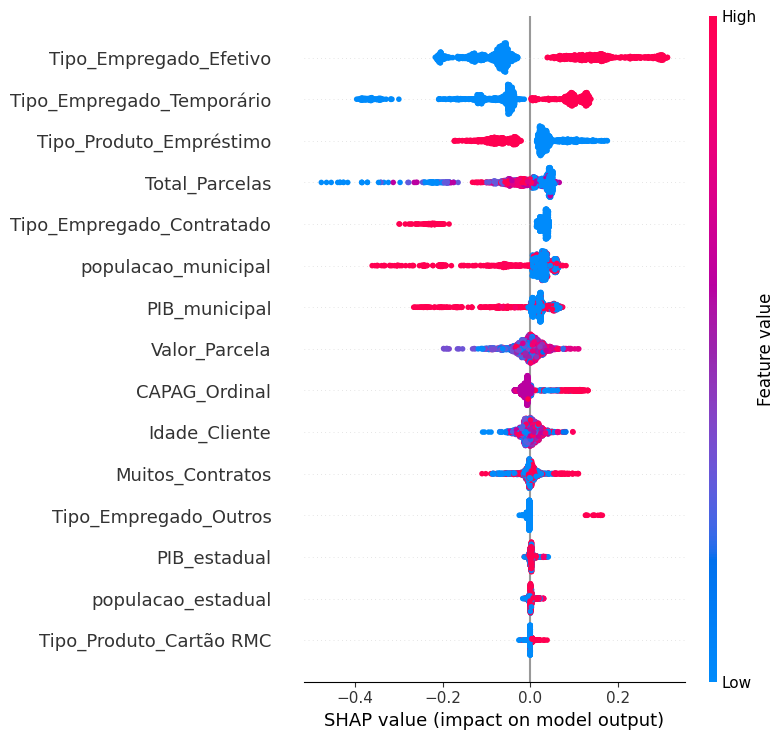


----------------------------------------
   DIAGNÓSTICO DE IMPORTÂNCIA DE FEATURES
----------------------------------------

--- Top 10 Features (Importância interna do modelo) ---

                      Feature  Importance
14  Tipo_Empregado_Temporário    0.161583
0              Total_Parcelas    0.146867
11  Tipo_Empregado_Contratado    0.112495
1               Valor_Parcela    0.106877
4         populacao_municipal    0.099097
5               PIB_municipal    0.087477
12     Tipo_Empregado_Efetivo    0.083458
3               Idade_Cliente    0.081138
10    Tipo_Produto_Empréstimo    0.040564
8               CAPAG_Ordinal    0.028049


--- Top 10 Features (Média do valor absoluto SHAP) ---

                      Feature  MeanAbsSHAP
12     Tipo_Empregado_Efetivo     0.121426
14  Tipo_Empregado_Temporário     0.101075
10    Tipo_Produto_Empréstimo     0.055256
0              Total_Parcelas     0.050880
11  Tipo_Empregado_Contratado     0.047146
4         populacao_municipal     0.045

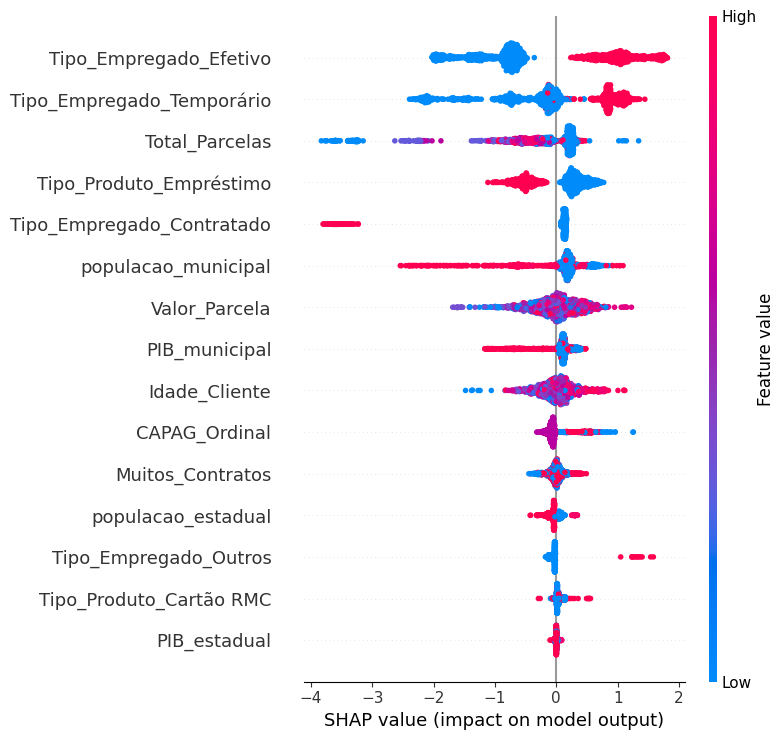


----------------------------------------
   DIAGNÓSTICO DE IMPORTÂNCIA DE FEATURES
----------------------------------------

--- Top 10 Features (Importância interna do modelo) ---

                      Feature  Importance
11  Tipo_Empregado_Contratado    0.265315
14  Tipo_Empregado_Temporário    0.198058
12     Tipo_Empregado_Efetivo    0.096511
15  Esfera_convenio_Municipal    0.085040
6          populacao_estadual    0.047278
13      Tipo_Empregado_Outros    0.044012
7                PIB_estadual    0.042481
0              Total_Parcelas    0.038285
5               PIB_municipal    0.036917
8               CAPAG_Ordinal    0.036588


--- Top 10 Features (Média do valor absoluto SHAP) ---

                      Feature  MeanAbsSHAP
12     Tipo_Empregado_Efetivo     1.008505
14  Tipo_Empregado_Temporário     0.697787
0              Total_Parcelas     0.536559
10    Tipo_Produto_Empréstimo     0.405431
11  Tipo_Empregado_Contratado     0.402519
4         populacao_municipal     0.366

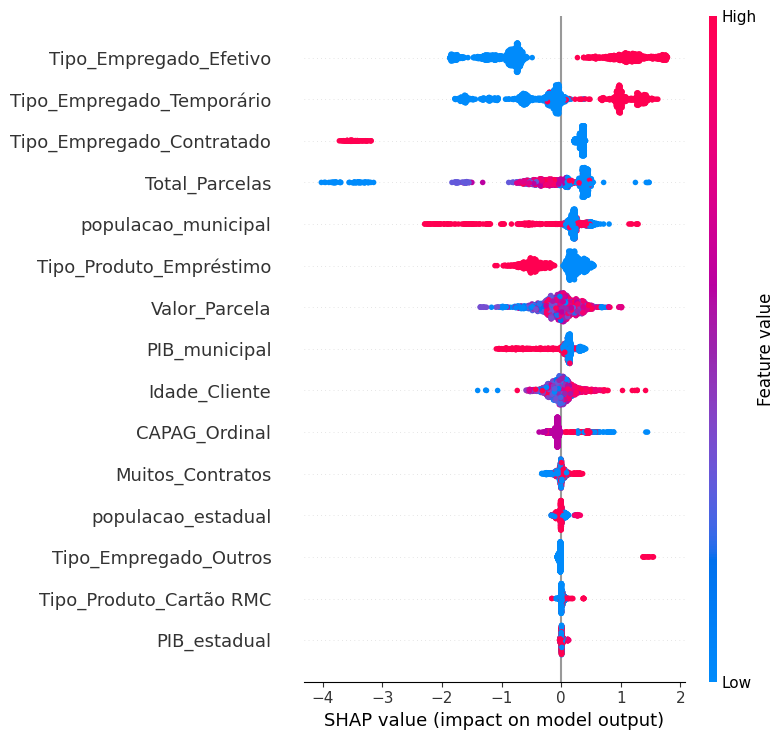


----------------------------------------
   DIAGNÓSTICO DE IMPORTÂNCIA DE FEATURES
----------------------------------------

--- Top 10 Features (Importância interna do modelo) ---

                      Feature  Importance
1               Valor_Parcela        3063
3               Idade_Cliente        2713
0              Total_Parcelas        1590
4         populacao_municipal        1046
5               PIB_municipal         725
8               CAPAG_Ordinal         402
10    Tipo_Produto_Empréstimo         357
2            Muitos_Contratos         344
14  Tipo_Empregado_Temporário         289
12     Tipo_Empregado_Efetivo         273


--- Top 10 Features (Média do valor absoluto SHAP) ---

                      Feature  MeanAbsSHAP
12     Tipo_Empregado_Efetivo     1.057781
14  Tipo_Empregado_Temporário     0.699843
11  Tipo_Empregado_Contratado     0.587249
0              Total_Parcelas     0.504095
4         populacao_municipal     0.358776
10    Tipo_Produto_Empréstimo     0.331

In [ ]:
print("\n\n" + "#"*88)
print("#   RESULTADOS FINAIS PARA OS MODELOS OTIMIZADOS   #")
print("#"*88)

# Itera sobre cada modelo que foi otimizado
for nome_modelo, melhores_params in params_otimizados_dict.items():
    print("\n" + "="*88)
    print(f"   PROCESSANDO MODELO FINAL: {nome_modelo}")
    print("="*88)
    pipeline_base = modelos_para_otimizar[nome_modelo]['pipeline'] # vou reutilizar o mesmo pipe   
    modelo_final_sem_pipe = pipeline_base.steps[-1][1].__class__(**melhores_params, random_state=42)  #  instancia do modelo otimizado
    pipeline_final = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', modelo_final_sem_pipe)]) # pipe final
    print(f"Treinando {nome_modelo} otimizado...") # retreino com a validation
    pipeline_final.fit(X_train_val, y_train_val)
    
    # agora vamos ver no conjunto de teste:
    y_pred_final = pipeline_final.predict_proba(X_test)[:, 1]
    auc_final = roc_auc_score(y_test, y_pred_final)
    print(f"\n🚀 Performance FINAL de '{nome_modelo}' no conjunto de teste: ROC-AUC = {auc_final:.4f}")

    # Chame os gráficos do shap: 
    explicar_e_diagnosticar_modelo(pipeline_final, X_train, X_test)



   GERANDO GRÁFICOS DE DEPENDÊNCIA PARCIAL (PDP/ICE) PARA O MODELO: LightGBM

<UPDT:> Gráfico de Dependência Parcial (PDP)...


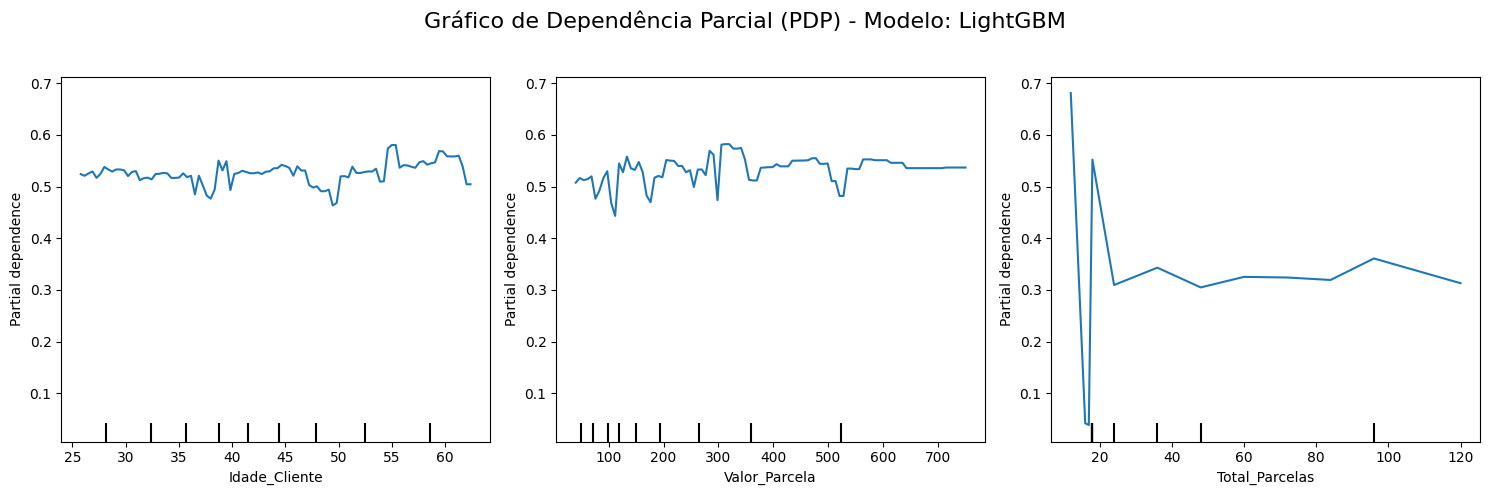


<UPDT:> Gráfico de Expectativa Condicional Individual (ICE)...


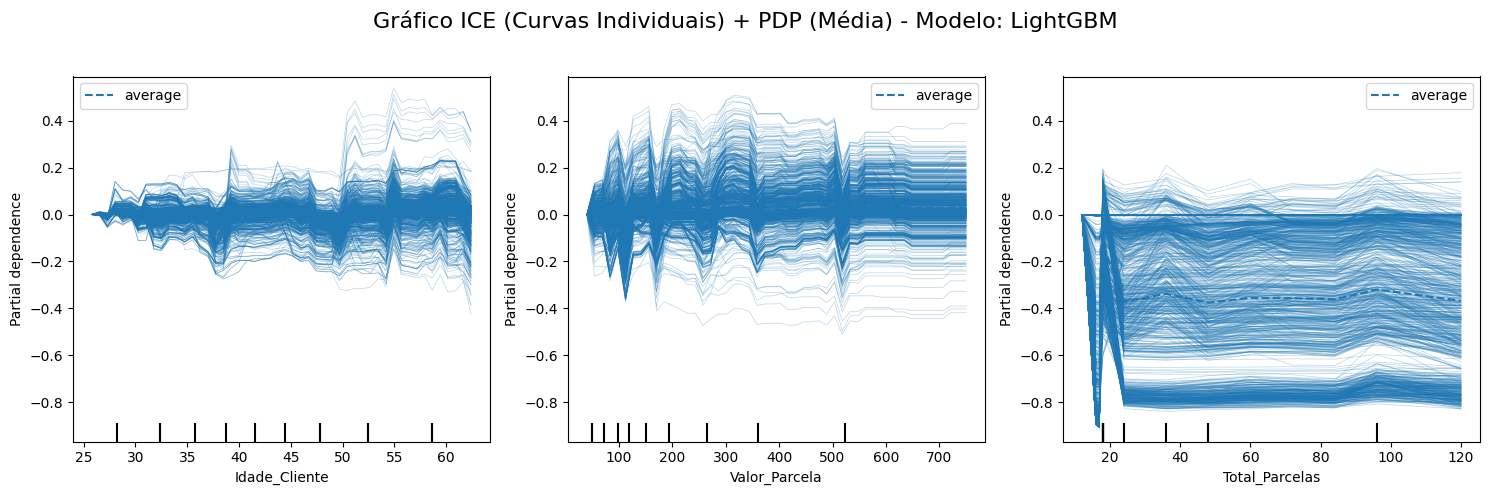


[INFO] Gerando Gráfico de Dependência Parcial (PDP) para Features Categóricas...
[AVISO] Não foi possível gerar o gráfico para features categóricas: input_features is not equal to feature_names_in_


In [30]:

#* ####################################################################
#* Referência: 
#* https://easyml.medium.com/a-complete-guide-to-ice-plots-037c8e5ac9f1
#* ####################################################################
print("\n" + "="*88)
print(f"   GERANDO GRÁFICOS DE DEPENDÊNCIA PARCIAL (PDP/ICE) PARA O MODELO: {nome_modelo}")
print("="*88)


features_numericas_para_plotar = ['Idade_Cliente', 'Valor_Parcela', 'Total_Parcelas']
features_categoricas_para_plotar = ['Tipo_Produto', 'Esfera_convenio']
#* ####################################################################
#* GRAFICO 1: PDP (A CURVA MÉDIA)
print("\n<UPDT:> Gráfico de Dependência Parcial (PDP)...")
fig, ax = plt.subplots(figsize=(15, 5), ncols=len(features_numericas_para_plotar))
fig.suptitle(f'Gráfico de Dependência Parcial (PDP) - Modelo: {nome_modelo}', fontsize=16)

display_pdp = PartialDependenceDisplay.from_estimator(
    estimator=pipeline_final,
    X=X_test,
    features=features_numericas_para_plotar,
    kind='average', # 'average' gera apenas a curva média (PDP)
    ax=ax
)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta o layout para o título não sobrepor
plt.show()
#* ####################################################################
#*GRAFICO 2: PDP + ICE (CURVAS INDIVIDUAIS + MÉDIA)
print("\n<UPDT:> Gráfico de Expectativa Condicional Individual (ICE)...")
fig, ax = plt.subplots(figsize=(15, 5), ncols=len(features_numericas_para_plotar))
fig.suptitle(f'Gráfico ICE (Curvas Individuais) + PDP (Média) - Modelo: {nome_modelo}', fontsize=16)

display_ice = PartialDependenceDisplay.from_estimator(
    estimator=pipeline_final,
    X=X_test,
    features=features_numericas_para_plotar,
    kind='both', # mantenho o a de média bem no meio
    n_jobs=-1,
    grid_resolution=50,
    centered=True, # centralizando da pra ver os slopes 
    n_cols=len(features_numericas_para_plotar),
    ax=ax
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#* ####################################################################
# **GRÁFICO 3: PDP PARA FEATURES CATEGÓRICAS**
print("\n[INFO] Gerando Gráfico de Dependência Parcial (PDP) para Features Categóricas...")
# É necessário obter os nomes das colunas após o one-hot encoding para features categóricas
try:
    preprocessor = pipeline_final.named_steps['preprocessor'] # parecido com oq eu fiz antes
    cat_transformer = preprocessor.named_transformers_['cat']
    onehot_encoder = cat_transformer.named_steps['onehot']
    
    #* map dos nomes originais
    encoded_feature_names = onehot_encoder.get_feature_names_out(features_categoricas_para_plotar)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    PartialDependenceDisplay.from_estimator(
        pipeline_final,
        X_test,
        features=features_categoricas_para_plotar, # A função lida com as features originais
        categorical_features=features_categoricas_para_plotar,
        ax=ax
    )
    fig.suptitle(f'PDP para Features Categóricas - Modelo: {nome_modelo}', fontsize=16)
    plt.xticks(rotation=15)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"[AVISO] Não foi possível gerar o gráfico para features categóricas: {e}")

### Stats Models

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)  #! !!!!! 

# TRATAR DADOS 
df_sm = df_ml.copy()
df_sm.columns = df_sm.columns.str.replace(' ', '_', regex=False).str.replace('[^A-Za-z0-9_]+', '', regex=True)
#(ele nao parece aceitar espaco, ç, etc)
df_sm.dropna(inplace=True) # para garantir, nao deve fazer dfrença
print("="*80)
print("Nomes das colunas limpos para o statsmodels:")
print(df_sm.columns.tolist())
print("="*80)

# REGRESSÃO LINEAR (OLS)
# OBJETIVO: Entender quais fatores influenciam a QUANTIDADE de dias em atraso.
# como é reg linear, nao adianta tentar chegar a fatos binários, e sim a quantidades

print("\n### 1. Regressão Linear (OLS) para 'max_dias_atraso' ###\n")
target_ols = 'max_dias_atraso'
categorical_features = df_sm.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numeric_features = df_sm.select_dtypes(include=np.number).columns.tolist() # identifico features

#? ---------- removo colunas inúteis, como o próprio alvo, ou códigos --------------------------------------------------------------------------------
predictors = [col for col in df_sm.columns if col not in ['CCB', 'max_dias_atraso'] + [c for c in df_sm.columns if 'Vencido' in c]]
formula_parts = []
for col in predictors:
    if col in categorical_features:
        formula_parts.append(f"C({col})")
    else:
        formula_parts.append(col)
        
formula_ols = f"{target_ols} ~ " + " + ".join(formula_parts)

print(f"Fórmula utilizada:\n{formula_ols}\n")

# TREINAMENTO
model_ols = smf.ols(formula=formula_ols, data=df_sm).fit()

#SUMÁRIO
print(model_ols.summary())



Nomes das colunas limpos para o statsmodels:
['CCB', 'Total_Parcelas', 'Valor_Parcela', 'Tipo_Produto', 'Tipo_Empregado', 'Esfera_convenio', 'Muitos_Contratos', 'Idade_Cliente', 'populacao_municipal', 'PIB_municipal', 'populacao_estadual', 'PIB_estadual', 'CAPAG_Ordinal', 'max_dias_atraso', 'Vencido_1d_Flag', 'Vencido_30d_Flag', 'Vencido_60d_Flag', 'Vencido_90d_Flag']

### 1. Regressão Linear (OLS) para 'max_dias_atraso' ###

Fórmula utilizada:
max_dias_atraso ~ Total_Parcelas + Valor_Parcela + C(Tipo_Produto) + C(Tipo_Empregado) + C(Esfera_convenio) + Muitos_Contratos + Idade_Cliente + populacao_municipal + PIB_municipal + populacao_estadual + PIB_estadual + CAPAG_Ordinal

                            OLS Regression Results                            
Dep. Variable:        max_dias_atraso   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     273.5
D

#### Regressão Logística 
Abaixo modelo nos diz que a inadimplência severa é menos sobre o histórico de crédito (`Muitos_Contratos`) e mais sobre o **contexto do cliente e do produto**. O risco é uma combinação de quem o cliente é (idade), onde ele trabalha (esfera do convênio) e o tipo de produto que ele contratou.

Tipo Empregado foi removido por não convergir

In [12]:

# REGRESSÃO LOGÍSTICA (LOGIT) ---
# OBJETIVO: Entender quais fatores influenciam a PROBABILIDADE de um contrato
#           ter um atraso severo (>= 90 dias).
"""
# obs: estou removendo a variável 'Tipo_Empregado' que causou a falha de convergência
# devido ao problema de separação perfeita, no caso de 90 dias
"""
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

print("="*80)
print("### REFAZENDO A REGRESSÃO LOGÍSTICA SEM A VARIÁVEL 'Tipo_Empregado' ###")
print("="*80)

# Obter preditores e remover 'Tipo_Empregado'
preditores_originais = [col for col in df_sm.columns if col not in ['CCB', 'max_dias_atraso'] + [c for c in df_sm.columns if 'Vencido' in c]]
preditores_corrigidos = [p for p in preditores_originais if p != 'Tipo_Empregado'] #! se for diferente de 90, pode trocar isso

print("\n<DEBUG> Variáveis preditoras utilizadas nesta nova análise:")
print(preditores_corrigidos)

#! ########################################################
target_logit = 'Vencido_30d_Flag'

#! OBSERVAÇÂO: Você pode trocar 90d por 1d, 30d, etc.
#! estou deixando assim apenas para nao ficar muito massivo
#! ########################################################

formula_parts_corrigida = []
for col in preditores_corrigidos:
    if col in df_sm.select_dtypes(include=['object', 'category', 'bool']).columns:
        formula_parts_corrigida.append(f"C({col})")
    else:
        formula_parts_corrigida.append(col)
        
formula_logit_corrigida = f"{target_logit} ~ " + " + ".join(formula_parts_corrigida)

print(f"\n [INFO] fórmula utilizada:\n{formula_logit_corrigida}\n")

model_logit_corrigido = smf.logit(formula=formula_logit_corrigida, data=df_sm).fit()


# SUMÁRIO
print(model_logit_corrigido.summary())

print("\n\n" + "="*80)
print("--- Coeficientes do Modelo (Razão de Chances / Odds Ratio) ---")

odds_ratios_corrigido = pd.DataFrame({
    "Odds Ratio": np.exp(model_logit_corrigido.params),
    "P>|z|": model_logit_corrigido.pvalues
})
conf_int_corrigido = np.exp(model_logit_corrigido.conf_int())
conf_int_corrigido.columns = ['OR CI Inferior', 'OR CI Superior']
odds_ratios_corrigido = odds_ratios_corrigido.join(conf_int_corrigido)

print(odds_ratios_corrigido)

### REFAZENDO A REGRESSÃO LOGÍSTICA SEM A VARIÁVEL 'Tipo_Empregado' ###

<DEBUG> Variáveis preditoras utilizadas nesta nova análise:
['Total_Parcelas', 'Valor_Parcela', 'Tipo_Produto', 'Esfera_convenio', 'Muitos_Contratos', 'Idade_Cliente', 'populacao_municipal', 'PIB_municipal', 'populacao_estadual', 'PIB_estadual', 'CAPAG_Ordinal']

 [INFO] fórmula utilizada:
Vencido_30d_Flag ~ Total_Parcelas + Valor_Parcela + C(Tipo_Produto) + C(Esfera_convenio) + Muitos_Contratos + Idade_Cliente + populacao_municipal + PIB_municipal + populacao_estadual + PIB_estadual + CAPAG_Ordinal

         Current function value: 0.560587
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:       Vencido_30d_Flag   No. Observations:                 6838
Model:                          Logit   Df Residuals:                     6825
Method:                           MLE   Df Model:                           12
Date:                Thu, 28 Aug 2025  

## Referências
Abaixo estão os links que eu visitei para consultar dúvidas: 


machine learning - How to deal with possible data leakage in time series data? - Data Science Stack Exchange
https://datascience.stackexchange.com/questions/45575/how-to-deal-with-possible-data-leakage-in-time-series-data
Python Pandas: Keeping only dataframe rows containing first occurrence of an item - Stack Overflow
https://stackoverflow.com/questions/24136620/python-pandas-keeping-only-dataframe-rows-containing-first-occurrence-of-an-ite/24137060
python - Add column with number of days between dates in DataFrame pandas - Stack Overflow
https://stackoverflow.com/questions/22132525/add-column-with-number-of-days-between-dates-in-dataframe-pandas
Python Pandas max value in a group as a new column - Stack Overflow
https://stackoverflow.com/questions/35640364/python-pandas-max-value-in-a-group-as-a-new-column
python - Assign conditions from a list np.select and create a new column (pandas) - Stack Overflow
https://stackoverflow.com/questions/69824116/assign-conditions-from-a-list-np-select-and-create-a-new-column-pandas
python - Pandas get the age from a date (example: date of birth) - Stack Overflow
https://stackoverflow.com/questions/26788854/pandas-get-the-age-from-a-date-example-date-of-birth
Why do we use stratify in train_test_split | by aymuosmukherjee | Medium
https://medium.com/@aymuosmukherjee/why-do-we-use-stratify-in-train-test-split-e3eb296a5494
python - How can I align pandas get_dummies across training / validation / testing? - Stack Overflow
https://stackoverflow.com/questions/56738267/how-can-i-align-pandas-get-dummies-across-training-validation-testing
Feature Engineering in a Pipeline - Weijian Zhang
https://weijianzhg.com/blog/2021/feature-engineering/
Column Transformer with Mixed Types — scikit-learn 1.7.1 documentation
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
How Does the class_weight Parameter in Scikit-Learn Work? - GeeksforGeeks
https://www.geeksforgeeks.org/machine-learning/how-does-the-classweight-parameter-in-scikit-learn-work/
unbalanced classes - What is the proper usage of scale_pos_weight in xgboost for imbalanced datasets? - Cross Validated
https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
roc_auc_score — scikit-learn 1.7.1 documentation
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
F1 Score vs ROC AUC vs Accuracy vs PR AUC - Neptune.ai
https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
python - XGBoostClassifier: model.get_booster().get_score(importance_type="gain") not return entire feature importance - Stack Overflow
https://stackoverflow.com/questions/74067871/xgboostclassifier-model-get-booster-get-scoreimportance-type-gain-not-ret
